## Step 1: Import Libraries

- `pandas` and `numpy` help us work with data.

- `matplotlib` and `seaborn` are used to create charts and graphs.

- From `scikit-learn`, we import tools to split data, build a random forest model, and check how well the model performs.

- `compute_class_weight` helps us deal with class imbalance in the data.

- `thefuzz` is used for fuzzy string matching—useful when text isn’t exactly the same.

- `re` is Python’s tool for working with text patterns using regular expressions.

In [56]:
# imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from thefuzz import process
import warnings
import re
import io


## References

* [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Random Forest Classifier documentation  
* [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) train-test split documentation  
* [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html) compute class weight documentation  
* [Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html) metrics documentation (accuracy, confusion matrix, classification report)  
* [Pandas documentation](https://pandas.pydata.org/docs/) for data manipulation  
* [NumPy documentation](https://numpy.org/doc/) for numerical computing  
* [Matplotlib](https://matplotlib.org/stable/index.html) official documentation for plotting  
* [Seaborn](https://seaborn.pydata.org/) official documentation for statistical data visualization  
* [Medium article](https://medium.com/@jaimejcheng/data-exploration-and-visualization-with-seaborn-pair-plots-40e6d3450f6d) for Seaborn pair plots  
* [TheFuzz GitHub](https://github.com/seatgeek/thefuzz) for fuzzy string matching in Python  
* [Medium article](https://towardsdatascience.com/fuzzy-string-matching-in-python-68f240d910fe) explaining fuzzy matching in Python  
* [Hands-On Machine Learning book](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) for machine learning workflows and best practices  
* [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) for accessing open datasets  




## Step 2: Load and Prepare the Dataset

- Load the dataset from the Excel file `Cervical Cancer Datasets_.xlsx`.
- Save it as a CSV file named `cervical_cancer.csv` to make it easier to work with.
- Load the CSV file into a Pandas DataFrame called `data` for further analysis.

Note: We use `index=False` when saving to prevent Pandas from adding row numbers as a column.


In [57]:
import pandas as pd

# 2. Load Excel and Save as CSV
excel_path = 'Cervical Cancer Datasets_.xlsx'
csv_path = 'cervical_cancer.csv'

df = pd.read_excel(excel_path)
df.to_csv(csv_path,index=False)

# 3. Load CSV (use header=None only if the dataset has no headers)
data = pd.read_csv(csv_path)  # Remove `header=None` if headers are present

data


,Patient ID,Age,Sexual Partners,First Sexual Activity Age,HPV Test Result,Pap Smear Result,Smoking Status,STDs History,Region,Insrance Covered,Screening Type Last,Recommended Action,Unnamed: 12
0,P0001,18,4,15,NEGATIVE,N,N,Y,Pumwani,Y,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE,NaN
1,P0002,15,1,14,POSITIVE,N,Y,Y,Kakamega,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
2,P0003,34,1,9,POSITIVE,N,N,Y,Machakos,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
3,P0004,52,5,16,POSITIVE,N,Y,N,Embu,Y,HPV DNA,"FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION",NaN
4,P0005,46,3,21,POSITIVE,N,N,N,Mombasa,N,HPV DNA,FOR HPV VACCINE AND SEXUAL EDUCATION,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,P0096,31,4,16,POSITIVE,Y,Y,N,Machakos,N,PAP SMEAR,"FOR COLPOSCOPY BIOPSY, CYTOLOGY",NaN
96,P0097,35,5,11,NEGATIVE,N,Y,N,Mombasa,N,PAP SMEAR,REPEAT PAP SMEAR IN 3 YEARS,NaN
97,P0098,35,1,18,POSITIVE,N,Y,N,Kericho,N,HPV DNA,FOR ANUAL FOLLOW UP AND PAP SMEAR IN 3 YEARS,NaN
98,P0099,31,1,20,POSITIVE,Y,Y,N,Embu,Y,HPV DNA,"FOR COLPOSCOPY BIOPSY, CYTOLOGY",NaN


### Flag Duplicates

The `Patient ID` is treated as the unique identifier for each individual.

We check for duplicate records by comparing all other columns **except `Patient ID`**. If rows have the same values across at least 80% of the fields, they are flagged as potential duplicates.

A new column `is_duplicate` is added to the dataset to mark these cases.

All flagged records are then exported to `flagged_duplicates.csv` for manual checking and review, ensuring no important data is accidentally removed.


In [58]:
# Flag duplicates and export them for manual checking
data['is_duplicate'] = data.duplicated(subset=df.columns.difference(['Patient ID']), keep=False)
duplicates_df = data[data['is_duplicate'] == True]
duplicates_df.to_csv('flagged_duplicates.csv', index=False)

print(data.columns)
print("\n")
print(f"The data set has ( Total rows: {len(data)}, Total columns: {len(data.columns)})")


Index(['Patient ID', 'Age', 'Sexual Partners', 'First Sexual Activity Age',
       'HPV Test Result', 'Pap Smear Result', 'Smoking Status', 'STDs History',
       'Region', 'Insrance Covered', 'Screening Type Last',
       'Recommended Action', 'Unnamed: 12', 'is_duplicate'],
      dtype='object')


The data set has ( Total rows: 100, Total columns: 14)


### Inspect and Verify Data Quality

In this step, we perform a basic data audit:

- Load the dataset from the CSV file.
- Preview the data using `.head()` to understand its structure.
- Use `.info()` to check data types and identify columns with missing values.
- Count missing values per column to assess data completeness.
- Print all unique values for each column to inspect potential inconsistencies or unexpected entries (e.g., typos in categorical fields).
- Finally, we print the value counts for each column — including missing values — to evaluate how frequently each value appears. This helps identify:
  - Class imbalance
  - Invalid or rare values
  - Columns that may require cleaning or transformation

In [59]:
# Load the raw data
data = pd.read_csv("cervical_cancer.csv")

# Preview the first few rows
print(data.head())

# Overview of column names, data types, and non-null counts
print(data.info())

# Check for missing values in each column
print("Missing values per column:\n", data.isnull().sum())

# Show unique values and value counts for each column
for column in data.columns:
    print(f"--- Unique values for: {column} ---")
    print(data[column].unique())
    print(f"\n--- Value Counts for: {column} ---")
    print(data[column].value_counts(dropna=False))
    print("\n")



  Patient ID  Age  Sexual Partners  First Sexual Activity Age HPV Test Result  \
0      P0001   18                4                         15        NEGATIVE   
1      P0002   15                1                         14        POSITIVE   
2      P0003   34                1                          9        POSITIVE   
3      P0004   52                5                         16        POSITIVE   
4      P0005   46                3                         21        POSITIVE   

  Pap Smear Result Smoking Status STDs History     Region Insrance Covered  \
0                N              N            Y   Pumwani                 Y   
1                N              Y            Y  Kakamega                 N   
2                N              N            Y   Machakos                N   
3                N              Y            N      Embu                 Y   
4                N              N            N    Mombasa                N   

  Screening Type Last                       

## Step 3: Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) helps us deeply understand the structure, quality, and relationships within the data before applying any machine learning algorithms.

### EDA Goals:
- Identify variable types (categorical, numerical, binary)
- Explore distributions of key features
- Visualize relationships and potential predictors
- Detect class imbalance in the target variable
- Spot outliers or anomalies that may impact modeling
- Support decisions for further data cleaning or transformation

---

### Feature & Data Type Overview

We begin by checking the types of each column and the number of unique values. This helps us distinguish between categorical and numerical features and spot columns that need transformation or standardization.

---

### Known Data Quality Discrepancies

During initial inspection, several inconsistencies and typos were identified:

#### Column: `HPV Test Result`
- `"POSITIVE\n"` — extra newline character
- `"NEGAGTIVE"` — misspelling of `"NEGATIVE"`

#### Column: `Region`
- Inconsistent casing: `"Mombasa"` vs `"MOMBASA"`, `"Kitale"` listed multiple times with trailing spaces
- Spacing and capitalization differences

#### Column: `Recommended Action`
- Same recommendation repeated with:
  - Extra spaces: `"REPEAT PAP SMEAR IN 3 YEARS "` vs `"REPEAT PAP SMEAR IN 3 YEARS"`
  - Misspellings: `"BIOSPY"` instead of `"BIOPSY"`, `"COLOSCOPY"` instead of `"COLPOSCOPY"`
  - Concatenation: `"FORCOLPOSCOPY, CYTOLOGY THEN LASER THERAPY"`

#### Column: `Unnamed: 12`
- Largely empty (mostly `NaN`) — candidate for removal.

#### Column: `Insrance Covered`
- Misspelled — should be renamed to `"Insurance Covered"`

---

### 1. Outcome Class Imbalance

We check whether the target variable (e.g., HPV Test Result or Pap Smear Result) is imbalanced.

> Why it's important: Imbalanced datasets can mislead the model into favoring the dominant class, leading to poor generalization.

---

### 2. Distribution of Numeric Features

We explore numerical features like `Age`, `First Sexual Activity Age`, and `Sexual Partners` to check their distribution and spot outliers using histograms and boxplots.

This step helps:
- Identify skewness
- Detect abnormal values
- Guide transformation decisions

---

### 3. Binary Features Overview

Binary/categorical columns such as `Smoking Status`, `STDs History`, and `Insurance Covered` are analyzed to ensure:
- Consistency (e.g., "YES"/"NO" vs "Y"/"N")
- No missing or ambiguous values

Visualizing their distribution gives insight into population characteristics.

---

### 4. Categorical Variable Exploration

We examine values in columns like:
- `Region` – Check patient spread across different geographical locations
- `Screening Type Last` – Evaluate most commonly used screening methods
- `Recommended Action` – Understand typical medical advice given after testing

This helps us assess frequency, diversity, and inconsistencies in responses.

---

### 5. Correlation Matrix for Numerical Features

A correlation matrix (heatmap) shows how numerical features relate to each other. This helps detect:
- Redundant or highly correlated variables
- Relationships that may influence the model

Features explored include:
- `Age`
- `First Sexual Activity Age`
- `Sexual Partners`

---

### 6. Summary of Key Issues to Clean

| Column                 | Issue Type             | Action Needed                     |
|------------------------|------------------------|-----------------------------------|
| `HPV Test Result`      | Typos, extra characters| Normalize strings                 |
| `Region`               | Casing, spacing issues | Map to consistent labels          |
| `Recommended Action`   | Misspellings, spacing  | Standardize text                  |
| `Unnamed: 12`          | Mostly empty           | Drop this column                  |
| `Insrance Covered`     | Misspelled             | Rename to `Insurance Covered`     |

---

### Bonus: Scikit-learn Data Cleaning Pipeline (Optional)

To make cleaning reusable and organized, we can define custom classes using `scikit-learn` transformers and compose them into a pipeline.

Example concept:
- Create a transformer to clean and standardize `HPV Test Result`
- Chain transformers for cleaning multiple fields

Using pipelines ensures our data transformations are:
- Reproducible
- Modular
- Easily integrated into training workflows

---

### EDA Summary

- Confirmed the presence of text inconsistencies, typos, and formatting issues in categorical columns.
- Several numerical features show outliers or unusual values.
- The target variable is imbalanced, which may require resampling.
- These insights guide the next step: comprehensive data cleaning and transformation.


### 3.1: Initial Inspection of Raw Data

In this step, we load the raw cervical cancer dataset and perform a quick inspection to identify data quality issues before cleaning. Specifically, we:

- Suppress warning messages for a cleaner notebook display.
- Load the dataset from a CSV file and print its shape to understand how many rows and columns it contains.
- Print the column names to check for any typos or unnecessary fields.
- Display unique values from key columns like `HPV Test Result`, `Region`, and a sample of `Recommended Action` values to identify inconsistencies (e.g., typos, inconsistent formatting, or unexpected categories).
- Check for missing values in each column to determine which features may require imputation or removal during cleaning.

This preliminary scan helps us understand what kind of cleaning and standardization will be necessary to prepare the data for analysis.


In [60]:

warnings.filterwarnings('ignore')

# Load the raw data
print("Loading raw data...")
df = pd.read_csv('cervical_cancer.csv')
print(f"Original dataset shape: {df.shape}")
print("\n" + "="*50)
print("BEFORE CLEANING - Data Quality Issues:")
print("="*50)

# Show original data quality issues
print("1. Column names:")
print(df.columns.tolist())

print("\n2. Sample of problematic data:")
print("HPV Test Result unique values:", df['HPV Test Result'].unique())
print("Region unique values:", df['Region'].unique())
print("Recommended Action samples:")
for action in df['Recommended Action'].unique()[:5]:
    print(f"  - '{action}'")

print("\n3. Missing values:")
print(df.isnull().sum())

Loading raw data...
Original dataset shape: (100, 13)

BEFORE CLEANING - Data Quality Issues:
1. Column names:
['Patient ID', 'Age', 'Sexual Partners', 'First Sexual Activity Age', 'HPV Test Result', 'Pap Smear Result', 'Smoking Status', 'STDs History', 'Region', 'Insrance Covered', 'Screening Type Last', 'Recommended Action', 'Unnamed: 12']

2. Sample of problematic data:
HPV Test Result unique values: ['NEGATIVE' 'POSITIVE' 'NEGAGTIVE' 'POSITIVE\n']
Region unique values: ['Pumwani ' 'Kakamega ' 'Machakos' 'Embu ' 'Mombasa' 'NAKURU' 'Loitoktok'
 'Moi ' 'Garissa ' 'Kitale' 'Kakamega' 'Mombasa ' 'Garissa' 'Kericho'
 'Pumwani' 'Kericho ' 'Machakos ' 'Moi' 'Kitale ']
Recommended Action samples:
  - 'REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE'
  - 'FOR HPV VACCINE AND SEXUAL EDUCATION'
  - 'FOR HPV VACCINE, LIFESTYLE AND SEXUAL EDUCATION'
  - 'FOR COLPOSCOPY CYTOLOGY AND BIOPSY'
  - 'REPEAT PAP SMEAR IN 3 YEARS'

3. Missing values:
Patient ID                    0
Age                  

### 3.2: Data Cleaning and Standardization

In this step, we clean and standardize the cervical cancer dataset to improve data quality, remove inconsistencies, and prepare it for further analysis and modeling.

---

#### Step-by-Step Cleaning Breakdown:

1. **Create a Copy**  
   - We create a copy of the original DataFrame (`clean_df = df.copy()`) to preserve the raw data for reference or backup.

2. **Remove Unnecessary Columns**  
   - We drop columns like `Unnamed: 12`, which are often artifacts of Excel exports and contain mostly `NaN` or irrelevant data.

3. **Fix Column Name Typos**  
   - Rename incorrectly spelled column headers.  
     Example: `"Insrance Covered"` → `"Insurance Covered"`

4. **Clean `HPV Test Result` Column**  
   - Convert values to uppercase and strip whitespace.
   - Replace typos and inconsistent formats like:
     - `"NEGAGTIVE"` → `"NEGATIVE"`
     - `"POSITIVE\n"` → `"POSITIVE"`
   - This standardization allows consistent analysis and visualization.

5. **Clean and Standardize `Region` Names**  
   - Remove inconsistencies caused by case sensitivity and trailing spaces.
   - Use a mapping dictionary to unify variations:
     - `"MOMBASA"`, `"mombasa "` → `"Mombasa"`
     - `"PUMWANI"`, `"Pumwani "` → `"Pumwani"` etc.

6. **Clean Binary Columns (Y/N Values)**  
   - Columns like:
     - `Pap Smear Result`, `Smoking Status`, `STDs History`, `Insurance Covered`
   - We standardize these by:
     - Converting to uppercase
     - Stripping whitespace  
   This ensures we don’t treat `"Y"`, `"y "`, and `" Y"` as different values.

7. **Clean `Screening Type Last` Column**  
   - Normalize string values using `upper()` and `strip()` to handle inconsistent formatting.

8. **Handle Age Anomalies**  
   - Convert `Age` to numeric and clip unrealistic values:
     - Any age `< 10` or `> 100` is corrected to fall within that range.

9. **Fix First Sexual Activity Age Conflicts**  
   - Convert to numeric and check for logical errors:
     - Drop rows where `First Sexual Activity Age > Age`.

10. **Clean `Sexual Partners` Column**  
    - Convert to numeric, drop rows with non-numeric or missing values.

11. **Final String Cleanup**  
    - Strip all string-type columns of whitespace for consistency.

---


In [61]:
# Create a copy for cleaning
clean_df = df.copy()

print("\n" + "="*50)
print("APPLYING CLEANING TRANSFORMATIONS:")
print("="*50)


# 1. Remove unnecessary columns
print("1. Removing unnecessary columns...")
columns_to_drop = ['Unnamed: 12']
for col in columns_to_drop:
    if col in clean_df.columns:
        clean_df.drop(columns=[col], inplace=True)
        print(f"   Dropped column: {col}")
        

# 2. Fix column name typos
print("\n2. Fixing column name typos...")
column_renames = {
    'Insrance Covered': 'Insurance Covered'
}
clean_df.rename(columns=column_renames, inplace=True)
for old, new in column_renames.items():
    print(f"   Renamed '{old}' to '{new}'")
    

# 3. Clean HPV Test Result
print("\n3. Cleaning HPV Test Result...")
print(f"   Before: {clean_df['HPV Test Result'].unique()}")

clean_df['HPV Test Result'] = clean_df['HPV Test Result'].astype(str).str.upper().str.strip()



# Fix the problematic characters - using raw strings to avoid escape issues
hpv_replacements = {
    'NEGAGTIVE': 'NEGATIVE',
    'POSTIVE': 'POSITIVE',
    'NEGATVIE': 'NEGATIVE',
    'NEGATVE': 'NEGATIVE',
    'NEGATIVE\n':'NEGATIVE',
    'NEGATIVE ':'NEGATIVE',
    ' NEGATIVE ':'NEGATIVE',
    ' POSITIVE ':'POSITIVE',
    'POSITIVE\n':'POSITIVE'
}

# Handle newline characters separately
clean_df['HPV Test Result'] = clean_df['HPV Test Result'].str.replace('\n', '', regex=False)
clean_df['HPV Test Result'] = clean_df['HPV Test Result'].str.replace('\\n', '', regex=False)

# Apply other replacements
clean_df['HPV Test Result'] = clean_df['HPV Test Result'].replace(hpv_replacements)

print(f"   After: {clean_df['HPV Test Result'].unique()}")


# 4. Clean and standardize Region names
print("\n4. Cleaning and standardizing Region names...")
print(f"   Before: {sorted(clean_df['Region'].unique())}")

# First, strip whitespace and normalize case
clean_df['Region'] = clean_df['Region'].astype(str).str.strip()

# Create comprehensive region mapping to handle all variations
region_mapping = {
    # Mombasa variations
    'mombasa': 'Mombasa',
    'MOMBASA': 'Mombasa',
    'Mombasa': 'Mombasa',
    'mombasa ': 'Mombasa',
    'Mombasa ': 'Mombasa',
    'MOMBASA ': 'Mombasa',


      # Pumwani variations
    'pumwani': 'Pumwani',
    'PUMWANI': 'Pumwani',
    'Pumwani': 'Pumwani',
    'pumwani ': 'Pumwani',
    'Pumwani ': 'Pumwani',
    'PUMWANI ': 'Pumwani',
    
    # Embu variations
    'embu': 'Embu',
    'EMBU': 'Embu',
    'Embu': 'Embu',
    'embu ': 'Embu',
    'Embu ': 'Embu',
    'EMBU ': 'Embu',
    
    # Kakamega variations
    'kakamega': 'Kakamega',
    'KAKAMEGA': 'Kakamega',
    'Kakamega': 'Kakamega',
    'kakamega ': 'Kakamega',
    'Kakamega ': 'Kakamega',
    'KAKAMEGA ': 'Kakamega',
    
    # Machakos variations
    'machakos': 'Machakos',
    'MACHAKOS': 'Machakos',
    'Machakos': 'Machakos',
    'machakos ': 'Machakos',
    'Machakos ': 'Machakos',
    'MACHAKOS ': 'Machakos',
    
    # Nakuru variations
    'nakuru': 'Nakuru',
    'NAKURU': 'Nakuru',
    'Nakuru': 'Nakuru',
    'NAKURU ': 'Nakuru',
    
    # Moi variations
    'moi': 'Moi',
    'MOI': 'Moi',
    'Moi': 'Moi',
    'moi ': 'Moi',
    'Moi ': 'Moi',
    'MOI ': 'Moi',
    
  
  
    # Loitoktok variations
    'loitoktok': 'Loitoktok',
    'LOITOKTOK': 'Loitoktok',
    'Loitoktok': 'Loitoktok',
    'loitoktok ': 'Loitoktok',
    'Loitoktok ': 'Loitoktok',
    'LOITOKTOK ': 'Loitoktok',
    
    # Garissa variations
    'garissa': 'Garissa',
    'GARISSA': 'Garissa',
    'Garissa': 'Garissa',
    'garissa ': 'Garissa',
    'Garissa ': 'Garissa',
    'GARISSA ': 'Garissa',
    
    # Kericho variations
    'kericho': 'Kericho',
    'KERICHO': 'Kericho',
    'Kericho': 'Kericho',
    'kericho ': 'Kericho',
    'Kericho ': 'Kericho',
    'KERICHO ': 'Kericho',
    
    # Kitale variations
    'kitale': 'Kitale',
    'KITALE': 'Kitale',
    'Kitale': 'Kitale',
    'kitale ': 'Kitale',
    'Kitale ': 'Kitale',
    'KITALE ': 'Kitale'
}



# Apply region mapping
clean_df['Region'] = clean_df['Region'].replace(region_mapping)

print(f"   After: {sorted(clean_df['Region'].unique())}")


# 6. Clean binary columns (Y/N values)
print("\n6. Cleaning binary columns...")
binary_columns = ['Pap Smear Result', 'Smoking Status', 'STDs History', 'Insurance Covered']
for col in binary_columns:
    if col in clean_df.columns:
        print(f"   Cleaning {col}")
        print(f"      Before: {clean_df[col].unique()}")
        clean_df[col] = clean_df[col].astype(str).str.upper().str.strip()
        print(f"      After: {clean_df[col].unique()}")
        

# 7. Clean screening type
print("\n7. Cleaning Screening Type Last...")
if 'Screening Type Last' in clean_df.columns:
    print(f"   Before: {clean_df['Screening Type Last'].unique()}")
    clean_df['Screening Type Last'] = clean_df['Screening Type Last'].astype(str).str.upper().str.strip()
    print(f"   After: {clean_df['Screening Type Last'].unique()}")
    

# 8. Handle age anomalies
print("\n8. Handling age anomalies...")
print(f"   Age range before: {clean_df['Age'].min()} - {clean_df['Age'].max()}")
clean_df['Age'] = pd.to_numeric(clean_df['Age'], errors='coerce')
# Check for unrealistic ages
unrealistic_ages = clean_df[(clean_df['Age'] < 10) | (clean_df['Age'] > 100)]
if len(unrealistic_ages) > 0:
    print(f"   Found {len(unrealistic_ages)} unrealistic ages")
clean_df['Age'] = clean_df['Age'].clip(lower=10, upper=100)
print(f"   Age range after: {clean_df['Age'].min()} - {clean_df['Age'].max()}")

# 9. Handle First Sexual Activity Age anomalies
print("\n9. Handling First Sexual Activity Age anomalies...")
print(f"   First Sexual Activity Age range before: {clean_df['First Sexual Activity Age'].min()} - {clean_df['First Sexual Activity Age'].max()}")
clean_df['First Sexual Activity Age'] = pd.to_numeric(clean_df['First Sexual Activity Age'], errors='coerce')

# Check for impossible values (first sexual activity age > current age)
# Identify invalid rows
impossible_ages = clean_df['First Sexual Activity Age'] > clean_df['Age']

# Print how many invalid records were found
if impossible_ages.any():
    print(f"   Found {impossible_ages.sum()} records where first sexual activity age > current age")

    # Drop those rows from the DataFrame
    clean_df = clean_df[~impossible_ages]

# 10. Handling Sexual Partners    

print("\n10. Handling Sexual Partners...")

#  Convert to numeric, non-numeric values become NaN
clean_df['Sexual Partners'] = pd.to_numeric(clean_df['Sexual Partners'], errors='coerce')

# Show range before dropping
print(f"   Sexual Partners range before cleanup: {clean_df['Sexual Partners'].min()} - {clean_df['Sexual Partners'].max()}")

# Drop rows where 'Sexual Partners' is NaN
initial_count = len(clean_df)
clean_df = clean_df.dropna(subset=['Sexual Partners'])
dropped_count = initial_count - len(clean_df)

print(f"   Dropped {dropped_count} rows with missing or invalid 'Sexual Partners' values.")

# 11. Final cleanup - strip all string columns
print("\n11. Final cleanup...")
for col in clean_df.select_dtypes(include='object').columns:
    clean_df[col] = clean_df[col].astype(str).str.strip()

print("\n" + "="*50)
print("CLEANING COMPLETE - SUMMARY:")
print("="*50)
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {clean_df.shape}")
print(f"Columns after cleaning: {clean_df.columns.tolist()}")

# Show cleaned data quality
print("\nCleaned data quality:")
print("1. HPV Test Result values:", clean_df['HPV Test Result'].unique())
print("2. Regions:", sorted(clean_df['Region'].unique()))
print("3. Missing values after cleaning:")
print(clean_df.isnull().sum())





APPLYING CLEANING TRANSFORMATIONS:
1. Removing unnecessary columns...
   Dropped column: Unnamed: 12

2. Fixing column name typos...
   Renamed 'Insrance Covered' to 'Insurance Covered'

3. Cleaning HPV Test Result...
   Before: ['NEGATIVE' 'POSITIVE' 'NEGAGTIVE' 'POSITIVE\n']
   After: ['NEGATIVE' 'POSITIVE']

4. Cleaning and standardizing Region names...
   Before: ['Embu ', 'Garissa', 'Garissa ', 'Kakamega', 'Kakamega ', 'Kericho', 'Kericho ', 'Kitale', 'Kitale ', 'Loitoktok', 'Machakos', 'Machakos ', 'Moi', 'Moi ', 'Mombasa', 'Mombasa ', 'NAKURU', 'Pumwani', 'Pumwani ']
   After: ['Embu', 'Garissa', 'Kakamega', 'Kericho', 'Kitale', 'Loitoktok', 'Machakos', 'Moi', 'Mombasa', 'Nakuru', 'Pumwani']

6. Cleaning binary columns...
   Cleaning Pap Smear Result
      Before: ['N' 'Y']
      After: ['N' 'Y']
   Cleaning Smoking Status
      Before: ['N' 'Y']
      After: ['N' 'Y']
   Cleaning STDs History
      Before: ['Y' 'N']
      After: ['Y' 'N']
   Cleaning Insurance Covered
      Be

### 3.3: Final Validation and Saving of Cleaned Data

After applying the data cleaning transformations, we perform a final check and save the cleaned dataset for further analysis.

---

#### Steps Included:

1. **Save Cleaned Dataset**  
   - Export the cleaned `DataFrame` to a new CSV file named `'cervical_cancer_cleaned.csv'`.
   - This ensures the cleaned version is preserved and can be reused for further analysis or modeling.

2. **Preview Cleaned Data**  
   - Display the first 5 rows of the cleaned dataset using `.head()` to get a sense of the cleaned structure and content.

3. **Verify Key Columns**  
   - Use a custom `show_unique_values()` function to display unique values for critical categorical features such as:
     - `HPV Test Result`
     - `Region`
     - `Pap Smear Result`
     - `Smoking Status`
     - `STDs History`
     - `Insurance Covered`
     - `Screening Type Last`
   - This helps confirm that cleaning steps were effective in removing typos, inconsistencies, and formatting issues.

4. **Column-Wise Value Counts**  
   - The `print_all_value_counts()` function prints value counts for all columns in the dataset (including `NaNs`).
   - This helps detect any remaining anomalies and understand the distribution of each variable, which is critical for:
     - Identifying imbalances
     - Planning for encoding (e.g., one-hot, label)
     - Feature engineering

---


In [62]:
# Save cleaned data
clean_df.to_csv('cervical_cancer_cleaned.csv', index=False)
print("\nCleaned data saved as 'cervical_cancer_cleaned.csv'")

# Display first few rows
print("\nFirst 5 rows of cleaned data:")
print(clean_df.head())

# Show unique values for key columns to verify cleaning
print("\n" + "="*50)
print("VERIFICATION OF CLEANED DATA:")
print("="*50)

def show_unique_values(df, columns):
    for col in columns:
        if col in df.columns:
            print(f"\n{col}:")
            unique_vals = df[col].unique()
            if len(unique_vals) <= 10:
                print(f"  Values: {unique_vals}")
            else:
                print(f"  Total unique values: {len(unique_vals)}")
                print(f"  Sample: {unique_vals[:10]}")

verification_columns = ['HPV Test Result', 'Region', 'Pap Smear Result', 'Smoking Status', 
                       'STDs History', 'Insurance Covered', 'Screening Type Last']
show_unique_values(clean_df, verification_columns)


#Preview results
def print_all_value_counts(df):
    for column in df.columns:
        print(f"--- Value Counts for: {column} ---")
        print(df[column].value_counts(dropna=False))  # include NaNs in the count
        print("\n")

# Print unique values to check validity & quality:
print_all_value_counts(clean_df)

print("\n✅ Data cleaning completed successfully!")
print("✅ Ready for next step: Exploratory Data Analysis")



Cleaned data saved as 'cervical_cancer_cleaned.csv'

First 5 rows of cleaned data:
  Patient ID  Age  Sexual Partners  First Sexual Activity Age HPV Test Result  \
0      P0001   18                4                         15        NEGATIVE   
1      P0002   15                1                         14        POSITIVE   
2      P0003   34                1                          9        POSITIVE   
3      P0004   52                5                         16        POSITIVE   
4      P0005   46                3                         21        POSITIVE   

  Pap Smear Result Smoking Status STDs History    Region Insurance Covered  \
0                N              N            Y   Pumwani                 Y   
1                N              Y            Y  Kakamega                 N   
2                N              N            Y  Machakos                 N   
3                N              Y            N      Embu                 Y   
4                N              N      

# Data Visualization
In this section, we explore the dataset visually to understand distributions, relationships, and trends across various features. This is a crucial step in identifying:

- Imbalanced classes
- Outliers
- Skewed data
- Correlations between features

We use common plotting tools like:
- **Histograms** to explore the distribution of numeric values
- **Box plots** to detect outliers
- **Count plots** to analyze category frequency
- **Heatmaps** to examine feature correlation

These insights guide decisions for data preprocessing and feature selection before training the model.


In [63]:
import pandas as pd

# Load cleaned Excel file
final_df = pd.read_excel("cleaned_data.xlsx")

# Preview the data
print(" Data Preview ")
print(final_df.head())



 Data Preview 
   Age  Sexual Partners  First Sexual Activity Age HPV Test Result  \
0   18                4                         15        NEGATIVE   
1   15                1                         14        POSITIVE   
2   34                1                          9        POSITIVE   
3   52                5                         16        POSITIVE   
4   46                3                         21        POSITIVE   

  Pap Smear Result Smoking Status STDs History    Region Insurance Covered  \
0                N              N            Y   Pumwani                 Y   
1                N              Y            Y  Kakamega                 N   
2                N              N            Y  Machakos                 N   
3                N              Y            N      Embu                 Y   
4                N              N            N   Mombasa                 N   

  Screening Type Last                               Recommended Action  
0           PAP SMEAR 

In [64]:
# Get numerical columns (int or float)
numerical_cols = final_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Get categorical columns
categorical_cols = final_df.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)


Numerical Columns: ['Age', 'Sexual Partners', 'First Sexual Activity Age']
Categorical Columns: ['HPV Test Result', 'Pap Smear Result', 'Smoking Status', 'STDs History', 'Region', 'Insurance Covered', 'Screening Type Last', 'Recommended Action']


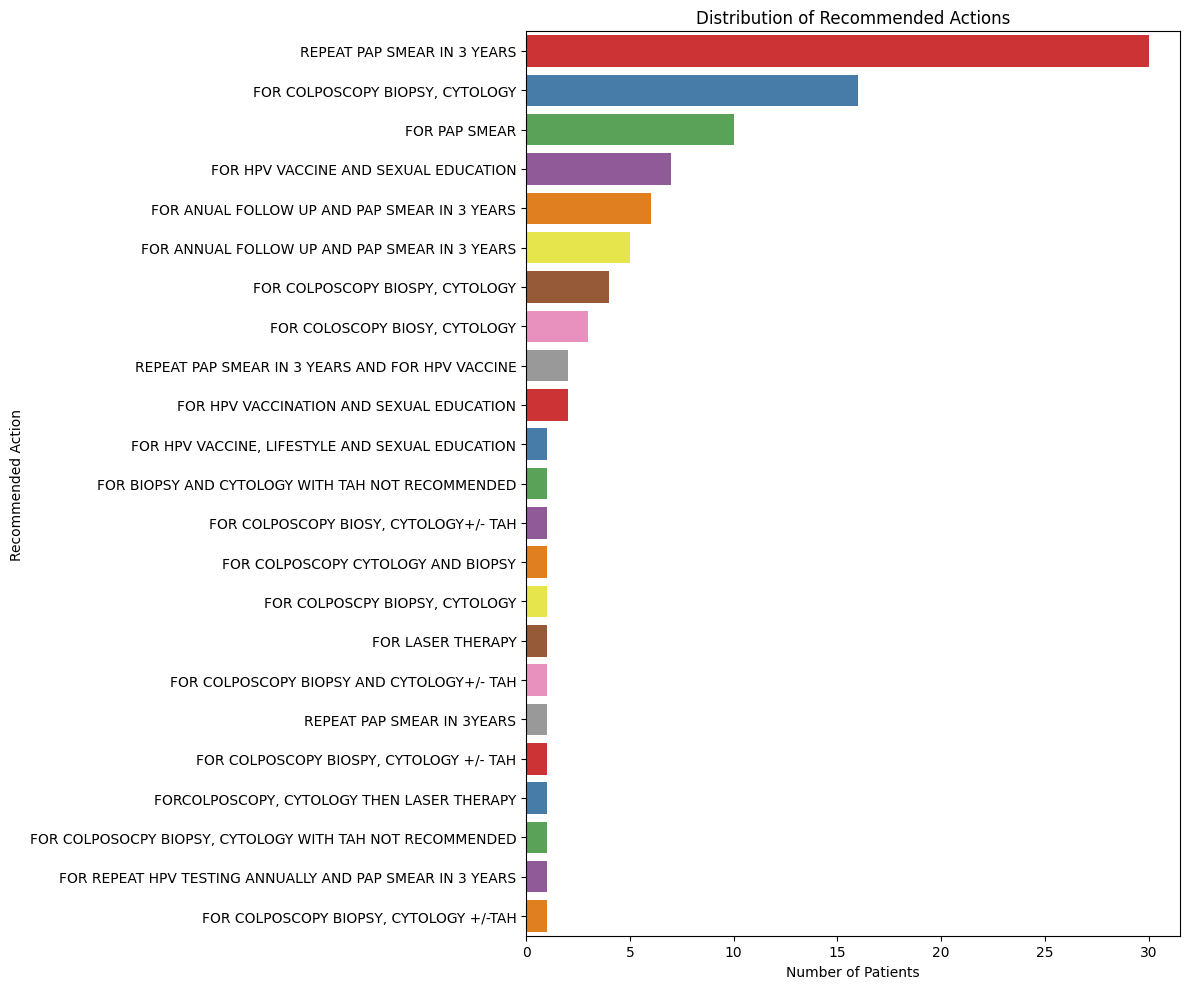

In [65]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# Distribution of Recommended Actions (from original column name)
plt.figure(figsize=(12, 10))
sns.countplot(
    data=final_df,
    y='Recommended Action',
    order=final_df['Recommended Action'].value_counts().index,
    palette='Set1'
    # palette='tab20'
)
plt.title("Distribution of Recommended Actions")
plt.xlabel("Number of Patients")
plt.ylabel("Recommended Action")
plt.tight_layout()
plt.show()


In [66]:
print(final_df.columns.tolist())


['Age', 'Sexual Partners', 'First Sexual Activity Age', 'HPV Test Result', 'Pap Smear Result', 'Smoking Status', 'STDs History', 'Region', 'Insurance Covered', 'Screening Type Last', 'Recommended Action']


In [67]:
print("\n Summary of Categorical Columns")
print(final_df[categorical_cols].describe())

# for col in categorical_cols:
#     print(f"\n--- {col} ---")
#     print(final_df[col].value_counts())


 Summary of Categorical Columns
       HPV Test Result Pap Smear Result Smoking Status STDs History   Region  \
count               98               98             98           98       98   
unique               2                2              2            2       11   
top           POSITIVE                N              N            N  Mombasa   
freq                51               64             60           50       15   

       Insurance Covered Screening Type Last           Recommended Action  
count                 98                  98                           98  
unique                 2                   3                           23  
top                    Y           PAP SMEAR  REPEAT PAP SMEAR IN 3 YEARS  
freq                  52                  37                           30  


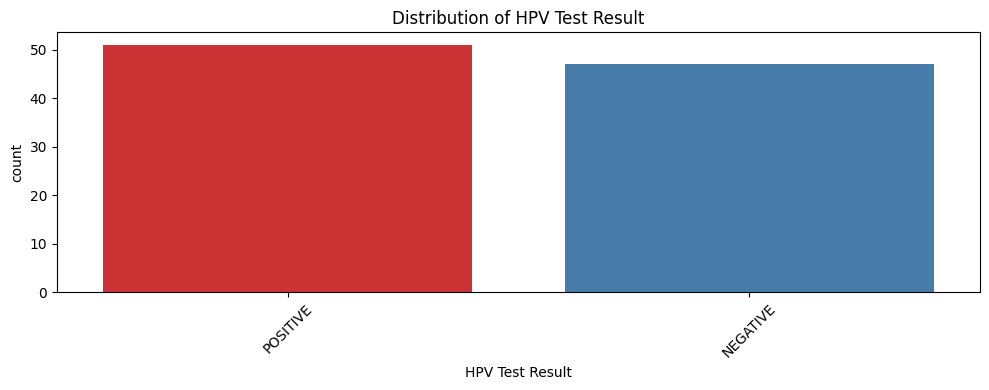

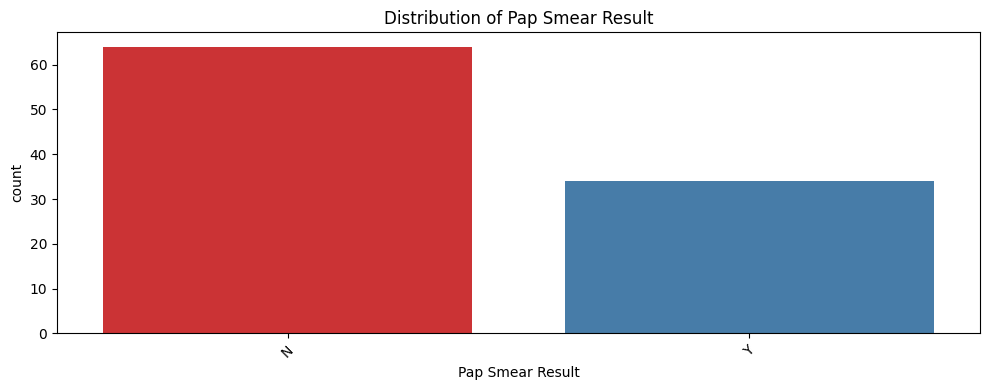

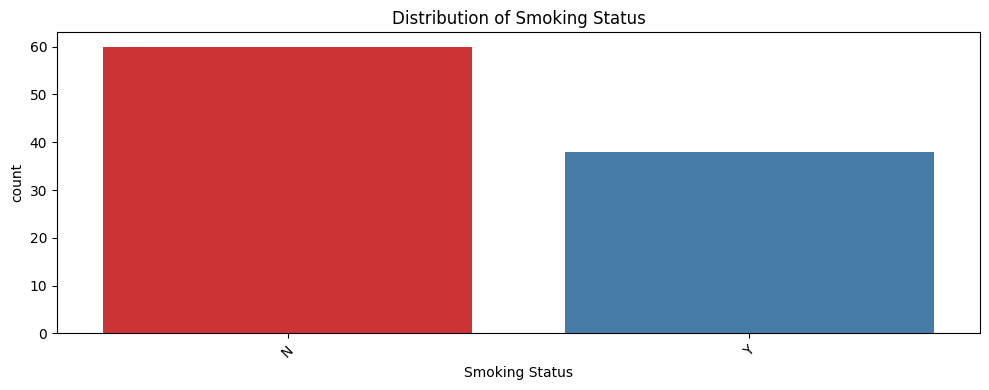

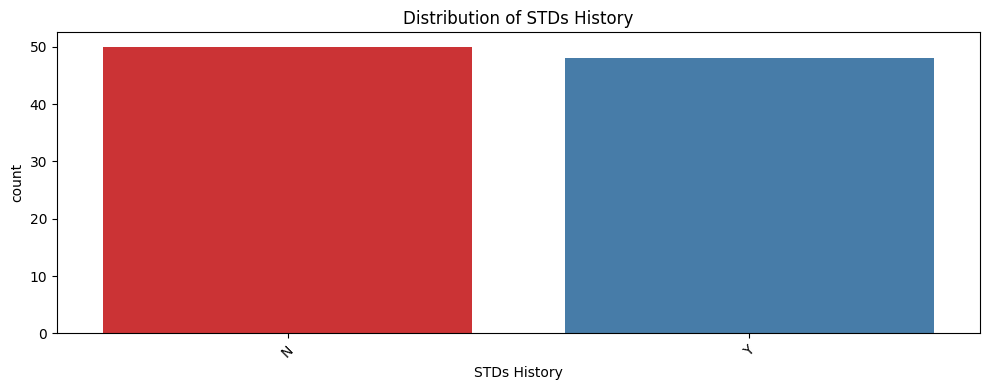

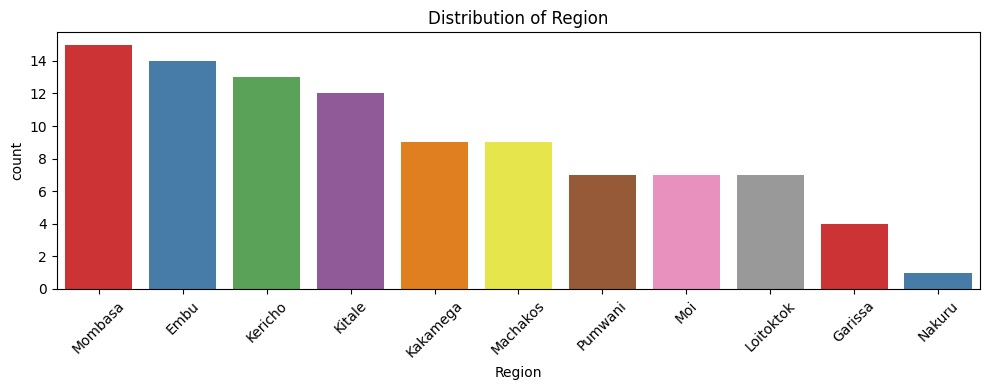

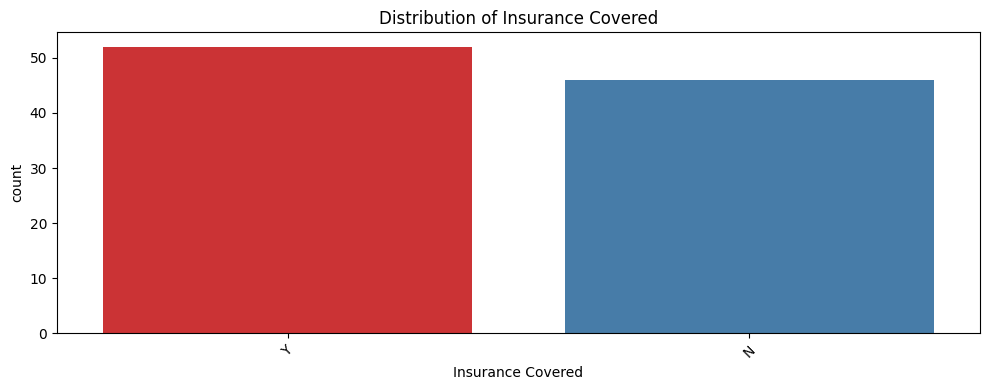

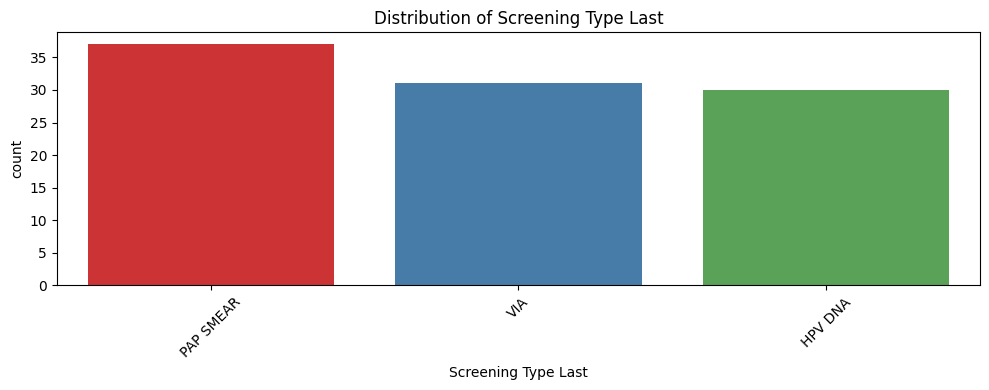

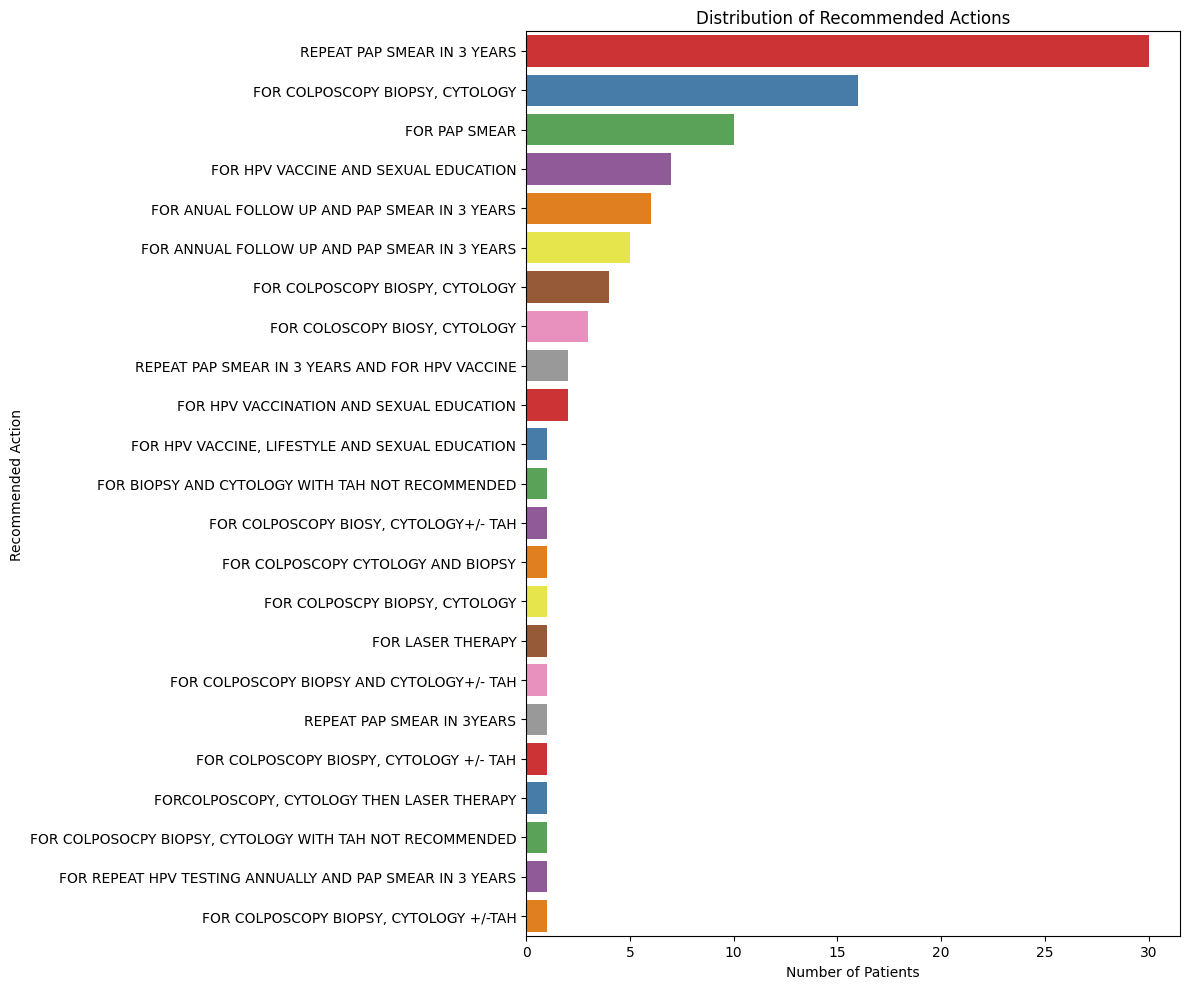

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot each categorical column EXCEPT Recommended Action
for col in categorical_cols:
    if col != 'Recommended Action':
        plt.figure(figsize=(10, 4))
        sns.countplot(data=final_df, x=col, order=final_df[col].value_counts().index, palette='Set1')
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Handle 'Recommended Action' separately (horizontally)
plt.figure(figsize=(12, 10))
sns.countplot(
    data=final_df,
    y='Recommended Action',
    order=final_df['Recommended Action'].value_counts().index,
    palette='Set1'
)
plt.title("Distribution of Recommended Actions")
plt.xlabel("Number of Patients")
plt.ylabel("Recommended Action")
plt.tight_layout()
plt.show()



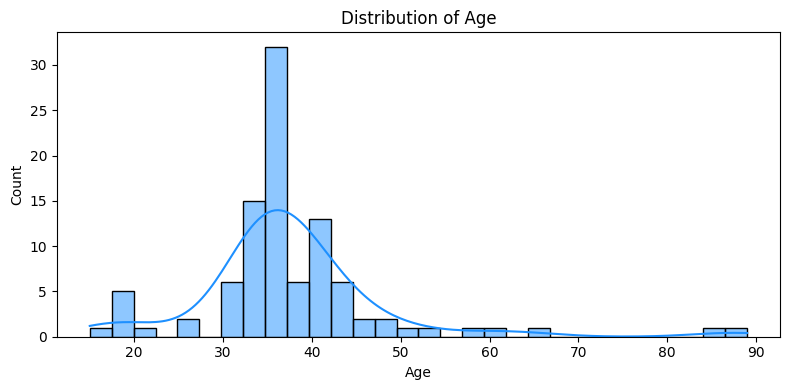

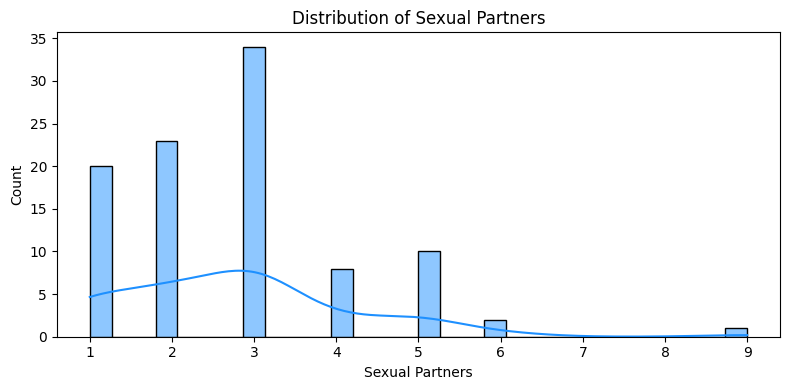

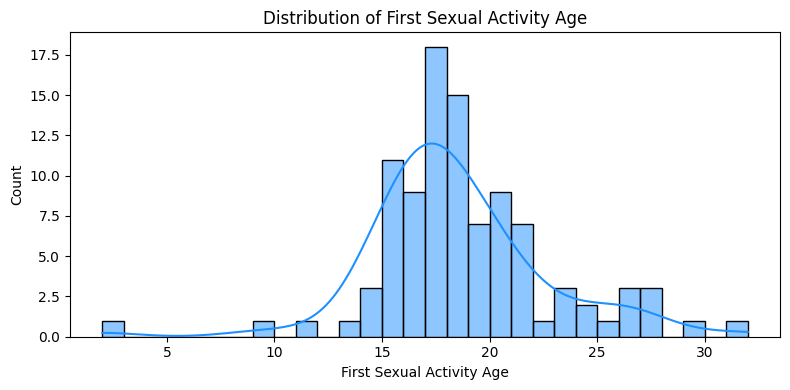

In [69]:
#Histograms for Numerical Features
numerical_cols = ['Age', 'Sexual Partners', 'First Sexual Activity Age']

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=final_df, x=col, kde=True, bins=30, color='dodgerblue')
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

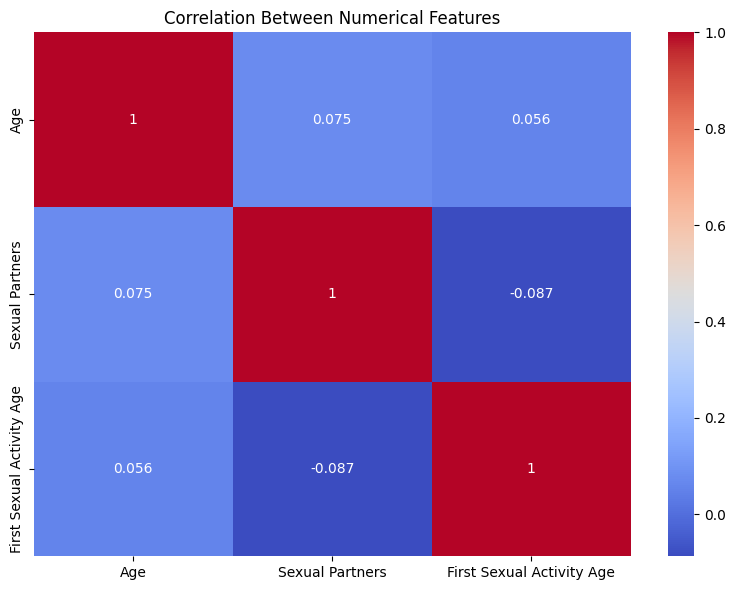

In [70]:
#Correlation Heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(final_df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numerical Features')
plt.tight_layout()
plt.show()

In [71]:
# 7. Summary Stats for Numeric Features
print("\n Summary of Numerical Columns ")
print(final_df[numerical_cols].describe())


 Summary of Numerical Columns 
             Age  Sexual Partners  First Sexual Activity Age
count  98.000000        98.000000                  98.000000
mean   37.683673         2.765306                  18.428571
std    10.831033         1.434487                   4.141816
min    15.000000         1.000000                   2.000000
25%    34.000000         2.000000                  16.000000
50%    36.000000         3.000000                  18.000000
75%    40.000000         3.000000                  20.000000
max    89.000000         9.000000                  32.000000


## Step 4: Data Processing


**Goal:** Clean the raw dataset to ensure consistency, standardization, and readiness for analysis or modeling.

---


### Standardizing Target Column Values (Recommendation)

Ensure the target column (`Recommendation`) is standardized and balanced to prevent model bias toward specific values.

---

- **Define canonical values**  
  Create a clean, consistent set of allowed values for the target column based on domain understanding.

- **Apply fuzzy matching with confidence scoring**  
  Use string similarity metrics (e.g., Levenshtein distance) to match variations of the values to their canonical forms.

- **Flag low-confidence matches for manual review**  
  If a value's match confidence is below a defined threshold (e.g., <80%), it is excluded from automatic cleaning and sent for manual validation.

---

> Standardizing target values is a critical step to ensure the model learns from meaningful, consistent labels and avoids biased predictions due to inconsistent or noisy data.


In [72]:
# This list contains the final, correct values to use.
canonical_values = [
    "REPEAT PAP SMEAR IN 3 YEARS",
    "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY",
    "FOR PAP SMEAR",
    "FOR HPV VACCINE AND SEXUAL EDUCATION",
    "FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS",
    "REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE",
    "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)",
    "FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)",
    "FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION",
    "FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH",
    "FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY",
    "FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS",
    "FOR LASER THERAPY"
]

# --- 2. Configuration for the Cleaner ---
TYPO_MAP = {
    'COLPOSOCPY': 'COLPOSCOPY', 'COLPOSCPY': 'COLPOSCOPY', 'COLOSCOPY': 'COLPOSCOPY',
    'BIOSPY': 'BIOPSY', 'BIOSY': 'BIOPSY', 'ANUAL': 'ANNUAL', 'VACCINATION': 'VACCINE'
}
CRITICAL_KEYWORDS = {
    'COLPOSCOPY', 'BIOPSY', 'CYTOLOGY', 'TAH', 'HPV', 'LASER', 'LIFESTYLE', 'ANNUALLY'
}

# --- 3. The Definitive Data Cleaning Function ---
def clean_column_strict(df, column_to_clean, canonical_list, threshold=80):
    """
    Cleans a DataFrame column using fuzzy matching combined with a STRICT keyword set equality rule.
    """
    if column_to_clean not in df.columns:
        raise ValueError(f"Column '{column_to_clean}' not found in the DataFrame.")

    def preprocess_and_get_keywords(text, typo_map):
        if not isinstance(text, str): return "", set()
        # Standardize to uppercase and correct typos
        processed_text = text.upper()
        for wrong, right in typo_map.items():
            processed_text = re.sub(r'\b' + wrong + r'\b', right, processed_text)
        
        # Extract the set of critical keywords
        keywords = {word for word in CRITICAL_KEYWORDS if word in processed_text}
        return processed_text, keywords

    cleaned_data = []

    # Pre-calculate keywords for the canonical list for efficiency
    canonical_keywords = {val: preprocess_and_get_keywords(val, {})[1] for val in canonical_list}

    for index, row in df.iterrows():
        raw_string = row[column_to_clean]
        
        if not isinstance(raw_string, str) or not raw_string.strip():
            cleaned_data.append((raw_string, 0, 'NO_DATA_PROVIDED'))
            continue

        processed_string, original_keywords = preprocess_and_get_keywords(raw_string, TYPO_MAP)
        
        # Get the top few potential matches instead of just one
        top_matches = process.extract(processed_string, canonical_list, limit=5)

        best_valid_match = None
        
        for potential_match, score in top_matches:
            if score < threshold:
                break # No need to check further if scores are too low

            # The CRITICAL check: The keyword sets must be identical
            if original_keywords == canonical_keywords[potential_match]:
                best_valid_match = (potential_match, score)
                break # Found the best possible valid match, stop searching

        if best_valid_match:
            final_value, final_score = best_valid_match
            status = 'OK'
        else:
            final_value = raw_string
            final_score = top_matches[0][1] if top_matches else 0 # Show score of best (but invalid) match
            status = 'NEEDS MANUAL REVIEW'

        cleaned_data.append((final_value, final_score, status))

    result_df = pd.DataFrame(cleaned_data, index=df.index, columns=[f'{column_to_clean}_Cleaned', f'{column_to_clean}_Confidence', f'{column_to_clean}_Status'])
    return df.join(result_df)

# main_df = pd.DataFrame(data, columns=['Recommended Action'])


# 2. Call the function to clean the specified column
# You provide your DataFrame, the column name, the list of correct values, and the confidence threshold.
final_df = clean_column_strict(
    df=clean_df,
    column_to_clean='Recommended Action',
    canonical_list=canonical_values,
    threshold=80
)

# 3. Display the results
print("--- Full Data Cleaning Results ---")
# Use .to_string() to ensure all columns are displayed without truncation
#print(final_df.to_string())

print("\n" + "="*80 + "\n")

# 4. Display only the rows that need human attention
print("--- Actions Flagged for Manual Review (Confidence < 80%) ---")
manual_review_df = final_df[final_df['Recommended Action_Status'] == 'NEEDS MANUAL REVIEW']

if manual_review_df.empty:
    print("No actions require manual review. All items met the 80% confidence threshold.")
else:
    print(manual_review_df[['Recommended Action', 'Recommended Action_Cleaned', 'Recommended Action_Confidence']].to_string())


print(f"   After: {final_df['Recommended Action_Cleaned'].unique()}")
final_df
final_df.to_excel("final_cleaned.xlsx",index=False)



--- Full Data Cleaning Results ---


--- Actions Flagged for Manual Review (Confidence < 80%) ---
No actions require manual review. All items met the 80% confidence threshold.
   After: ['REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE'
 'FOR HPV VACCINE AND SEXUAL EDUCATION'
 'FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION'
 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY' 'REPEAT PAP SMEAR IN 3 YEARS'
 'FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH'
 'FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)'
 'FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS' 'FOR PAP SMEAR'
 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)'
 'FOR LASER THERAPY' 'FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY'
 'FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS']


In [73]:
#Load the file
file_path = 'final_cleaned.xlsx'
df = pd.read_excel(file_path)
print("1. Removing unnecessary columns...")
columns_to_drop = ['Recommended Action','Recommended Action_Confidence','Recommended Action_Status','Patient ID']
for col in columns_to_drop:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)
df.to_excel('data_final.xlsx', index=False)

1. Removing unnecessary columns...


## Step 5: Data Preparation


**Goal:** Prepare the dataset for fair and effective model training by splitting the data and addressing class imbalances.

---


### 5.1 Data Splitting

- Perform a train-test split (e.g., 80/20) to evaluate model performance on unseen data.
- Encode target labels numerically using `LabelEncoder` to allow stratified sampling.
- Detect and duplicate any classes with only one instance to prevent stratification errors.
- Use **stratified splitting** to maintain class distribution in both train and test sets.
- Ensure reproducibility by setting a fixed random state.


In [74]:
# --- 1. Load Your Data ---
# Let's create a sample DataFrame that mimics your situation

data = pd.read_excel('data_final.xlsx')
df = pd.DataFrame(data)

# --- 2. DEFINE TARGET and SEPARATE X and y ---
target_column = 'Recommended Action_Cleaned'
y = df[target_column]
X = df.drop(columns=[target_column])


# --- 3. PRE-SPLIT STEP: LABEL ENCODE THE TARGET COLUMN ---
# This is required so that the 'stratify' parameter can work with numeric labels.
print("\n--- 3. Label Encoding Target Column (y) ---")
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Target column converted to numeric labels.")
print("-" * 60)


# --- 4. PRE-SPLIT STEP: HANDLE SINGLE-INSTANCE CLASSES for STRATIFICATION ---
# Stratify needs at least 2 members per class. We duplicate the singletons.
print("\n--- 4. Checking for and Fixing Single-Instance Classes ---")
class_counts = pd.Series(y_encoded).value_counts()
single_instance_classes = class_counts[class_counts < 2].index

X_fixed = X.copy()
y_fixed = y_encoded.copy()

if len(single_instance_classes) > 0:
    print(f"Found {len(single_instance_classes)} classes with only one sample. Duplicating them...")
    
    indices_to_duplicate = pd.Series(y_encoded).isin(single_instance_classes)
    
    X_to_duplicate = X[indices_to_duplicate]
    y_to_duplicate = y_encoded[indices_to_duplicate]
    
    X_fixed = pd.concat([X, X_to_duplicate], ignore_index=True)
    y_fixed = pd.concat([pd.Series(y_encoded), pd.Series(y_to_duplicate)], ignore_index=True).values
else:
    print("No single-instance classes found that would break stratification.")

print(f"Shape before fix: {X.shape}. Shape after fix: {X_fixed.shape}.")
print("-" * 60)

    
# --- 5. SPLIT THE DATA (CRITICAL LEAKAGE-PREVENTION STEP) ---
# We split the 'fixed' data. X_fixed STILL CONTAINS THE TEXT/CATEGORICAL COLUMNS.
print("\n--- 5. Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = train_test_split(
    X_fixed, y_fixed, 
    test_size=0.2,       # 20% for testing
    random_state=42,     # For reproducibility
    stratify=y_fixed     # Ensure class distribution is similar
)
print("Data successfully split.")
print(f"Training set size: {len(X_train)} rows")
print(f"Test set size: {len(X_test)} rows")
print("-" * 60)


# --- 6. ONE-HOT ENCODE THE FEATURE COLUMNS (POST-SPLIT) ---
# We learn the encoding schema ONLY from the training data to prevent data leakage.
print("\n--- 6. One-Hot Encoding Categorical Features ---")
# Automatically identify which columns are numeric and which are categorical from the training set
numeric_features = X_train.select_dtypes(include='number').columns
categorical_features = X_train.select_dtypes(include='object').columns

print(f"Identified Numeric Features: {list(numeric_features)}")
print(f"Identified Categorical Features: {list(categorical_features)}")

# Create the encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# FIT the encoder ONLY on the TRAINING data's categorical columns
encoder.fit(X_train[categorical_features])

# TRANSFORM both the training and testing data's categorical columns
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_train.index
)
X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_features]),
    columns=encoder.get_feature_names_out(categorical_features),
    index=X_test.index
)

# Reset index on all parts to ensure clean concatenation
X_train_numeric_reset = X_train[numeric_features].reset_index(drop=True)
X_test_numeric_reset = X_test[numeric_features].reset_index(drop=True)
X_train_encoded_reset = X_train_encoded.reset_index(drop=True)
X_test_encoded_reset = X_test_encoded.reset_index(drop=True)

# Combine encoded categorical columns with the original numeric columns
X_train_processed = pd.concat([X_train_numeric_reset, X_train_encoded_reset], axis=1)
X_test_processed = pd.concat([X_test_numeric_reset, X_test_encoded_reset], axis=1)

print("\nFeatures have been successfully encoded.")
print(f"Shape of processed training features: {X_train_processed.shape}")
print(f"Shape of processed testing features: {X_test_processed.shape}")
print("-" * 60)



--- 3. Label Encoding Target Column (y) ---
Target column converted to numeric labels.
------------------------------------------------------------

--- 4. Checking for and Fixing Single-Instance Classes ---
Found 6 classes with only one sample. Duplicating them...
Shape before fix: (98, 10). Shape after fix: (104, 10).
------------------------------------------------------------

--- 5. Splitting Data into Training and Testing Sets ---
Data successfully split.
Training set size: 83 rows
Test set size: 21 rows
------------------------------------------------------------

--- 6. One-Hot Encoding Categorical Features ---
Identified Numeric Features: ['Age', 'Sexual Partners', 'First Sexual Activity Age']
Identified Categorical Features: ['HPV Test Result', 'Pap Smear Result', 'Smoking Status', 'STDs History', 'Region', 'Insurance Covered', 'Screening Type Last']

Features have been successfully encoded.
Shape of processed training features: (83, 27)
Shape of processed testing features: 

### 5.2 Manually Defining Class Weights


Incorporate domain (clinical) knowledge to assign **custom class weights** that reflect the **importance or rarity** of each medical recommendation. These weights will later be used during model training to reduce bias toward majority classes and emphasize critical outcomes.

---

###  What This Step Does:

- Creates a **label mapping** between the original class names and their encoded numeric labels using `LabelEncoder`.
- Manually defines a dictionary of weights where:
  - **Higher weight** = **more important class** (higher penalty for misclassification).
  - **Lower weight** = more common or less critical class.
- Ensures that **all classes** present in the training data are assigned a weight.

---

###  Example Mapping Strategy:
| Recommendation (Class)                                | Weight | Reason                     |
|--------------------------------------------------------|--------|----------------------------|
| FOR LASER THERAPY                                      | 30.0   | Critically important       |
| FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH               | 25.0   | High-risk case             |
| REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE        | 1.0    | Common/majority class      |
| FOR HPV VACCINE AND SEXUAL EDUCATION                   | 1.2    | Slightly less common       |

>  These weights will later be passed into the model using the `class_weight` parameter (e.g., in `RandomForestClassifier`).

---

 **Outcome:** A `manual_weights_dict` is created to **inform the model of clinical priorities**, improving the model’s fairness and medical relevance.


In [75]:
print("\n--- 5. Manually Defining Class Weights Based on Clinical Importance ---")

# First, let's create a mapping from class names to their encoded labels for clarity
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class Label Mapping:")
print(label_mapping)

# ===================================================================================
# THIS IS WHERE YOU APPLY YOUR DOMAIN KNOWLEDGE.
# You create the dictionary from scratch. Higher weight = higher penalty for getting it wrong.
# You MUST provide a weight for every class label present in y_train.
# ===================================================================================
manual_weights_dict = {
    label_mapping['REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE']: 1.0, # Majority/common class
    label_mapping['FOR HPV VACCINE AND SEXUAL EDUCATION']: 1.2, # Slightly less common
    label_mapping['FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY']: 20.0, # IMPORTANT - High penalty
    label_mapping['FOR LASER THERAPY']: 30.0, # CRITICALLY IMPORTANT - Very high penalty
    label_mapping['FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH']: 25.0, # IMPORTANT - High penalty
    label_mapping["REPEAT PAP SMEAR IN 3 YEARS"]:10.0,
    label_mapping["FOR PAP SMEAR"]:5.0,
    label_mapping["FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS"]:20.0,
    label_mapping["FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION"]:1.5,
    label_mapping["FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY"] :30.0,
    label_mapping["FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS"]:25.0,
    label_mapping['FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)']: 20.0,
    label_mapping['FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)']: 20.0
}

print("\nCustom Weights Defined:")
print(manual_weights_dict)
print("-" * 60)



--- 5. Manually Defining Class Weights Based on Clinical Importance ---
Class Label Mapping:
{'FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS': np.int64(0), 'FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)': np.int64(1), 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY': np.int64(2), 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)': np.int64(3), 'FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH': np.int64(4), 'FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY': np.int64(5), 'FOR HPV VACCINE AND SEXUAL EDUCATION': np.int64(6), 'FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION': np.int64(7), 'FOR LASER THERAPY': np.int64(8), 'FOR PAP SMEAR': np.int64(9), 'FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS': np.int64(10), 'REPEAT PAP SMEAR IN 3 YEARS': np.int64(11), 'REPEAT PAP SMEAR IN 3 YEARS AND FOR HPV VACCINE': np.int64(12)}

Custom Weights Defined:
{np.int64(12): 1.0, np.int64(6): 1.2, np.int64(2): 20.0, np.int64(8): 30.0, np.int64(4): 25.0, np.int64(11): 10.0, np.int64(9): 5.0, np.int64(0)

##  STEP 6: Modeling

Train machine learning models to predict medical recommendations based on patient data, while incorporating clinical priorities and ensuring interpretability.

---

###  What This Step Covers:

- **Model Training:**  
  Train models like **Random Forest** and **Decision Tree** using the cleaned and prepared dataset.

- **Class Weights Integration:**  
  Apply custom class weights (from Step 5.2) to handle class imbalance and emphasize critical clinical cases.

- **Feature Importance Analysis:**  
  Use models like Random Forest to identify which features contribute most to predictions, aiding interpretability and potential clinical validation.

- **Model Comparison:**  
  Train multiple algorithms and evaluate them using metrics such as **accuracy**, **precision**, **recall**, and **F1-score** to select the most suitable model for deployment.

---

>  This step bridges the gap between data and decision-making, producing models that are both statistically sound and clinically meaningful.


###  6.1 : Random Forest Classifier

** Goal:**  
Identify and select the most influential features to improve model performance and interpretability.

---

###  Stage A: Calculate Feature Importance

- A preliminary **Random Forest Classifier** is trained on the **training data** only.
- **Custom class weights** are used during training to avoid bias toward the majority class.
- Feature importance scores are extracted from the trained model.
- The top features (e.g., top 14) are reviewed to understand which variables most impact the target prediction.

---

###  Stage B: Select Features Based on Importance

- A threshold-based approach is used to **automatically select the most important features**.
  - For example, selecting features whose importance is **above the median**.
- The selected features are used to transform both the training and test datasets into reduced versions:
  - `X_train_final` and `X_test_final`
- This **reduces dimensionality**, improves training efficiency, and may enhance model generalization.

---

>  This step ensures the model is trained on the **most relevant features**, minimizing noise and improving interpretability.


In [76]:



# --- Stage A: Calculate Feature Importance and Select Features (on training data) ---
print("\n--- A. Calculating Feature Importance on Training Data ONLY ---")

# We train a preliminary RandomForest model to get feature importances.
# It's good practice to use the class weights here too so the importance calculation
# is not biased towards features that are only useful for the majority class.
feature_selector_model = RandomForestClassifier(
    random_state=42,
    class_weight=manual_weights_dict
)
feature_selector_model.fit(X_train_processed, y_train)

# Get the importance scores
importances = feature_selector_model.feature_importances_
feature_names = X_train_processed.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

print("Top 14 most important features (learned from training data):")
print(importance_df.head(14))

# --- Stage B: Perform the Feature Selection ---
print("\n--- B. Selecting Features Based on Importance ---")

# We can use a threshold (e.g., select features with importance > 0.01)
# Or we can use a helper like SelectFromModel to automatically select them.
# 'threshold="median"' will select all features with importance greater than the median.
selector = SelectFromModel(feature_selector_model, threshold='median', prefit=True)

# Use the selector to get the final versions of our datasets
X_train_final = selector.transform(X_train_processed)
X_test_final = selector.transform(X_test_processed) # Apply same transformation to test set

print(f"\nOriginal number of features: {X_train_processed.shape[1]}")
print(f"Number of features selected: {X_train_final.shape[1]}")
print("-" * 60)



--- A. Calculating Feature Importance on Training Data ONLY ---
Top 14 most important features (learned from training data):
                        feature  importance
0                           Age    0.138739
2     First Sexual Activity Age    0.088938
4      HPV Test Result_POSITIVE    0.083882
6            Pap Smear Result_Y    0.079239
5            Pap Smear Result_N    0.073312
1               Sexual Partners    0.067859
3      HPV Test Result_NEGATIVE    0.061853
9                STDs History_N    0.040539
10               STDs History_Y    0.035816
26      Screening Type Last_VIA    0.034388
19               Region_Mombasa    0.031994
16             Region_Loitoktok    0.029020
24  Screening Type Last_HPV DNA    0.026688
22          Insurance Covered_N    0.022136

--- B. Selecting Features Based on Importance ---

Original number of features: 27
Number of features selected: 14
------------------------------------------------------------


### 6.2 Algorithm Selection  
**Goal:** Compare different classification models to select the best performer.

- Trained both **Random Forest** and **Decision Tree** classifiers using the selected features.
- Applied **custom class weights** to handle imbalance in clinical recommendations.
- Evaluated each model on test data using:
  - **Accuracy**
  - **Classification Report** (Precision, Recall, F1-Score)
  - **Confusion Matrix** (visualized with heatmaps)
- Stored and compared results to guide final model selection.


--- Training and Evaluating: Random Forest ---
Random Forest trained successfully.
----------------------------------------
--- Training and Evaluating: Decision Tree ---
Decision Tree trained successfully.
----------------------------------------


              MODEL COMPARISON RESULTS

=============== Random Forest ===============

Overall Accuracy: 0.8095

Classification Report:
                                                            precision    recall  f1-score   support

             FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS       1.00      0.50      0.67         2
             FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)       0.00      0.00      0.00         0
                      FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY       1.00      1.00      1.00         5
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)       0.00      0.00      0.00         0
                  FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH       0.00      0.00      0.00         1
             

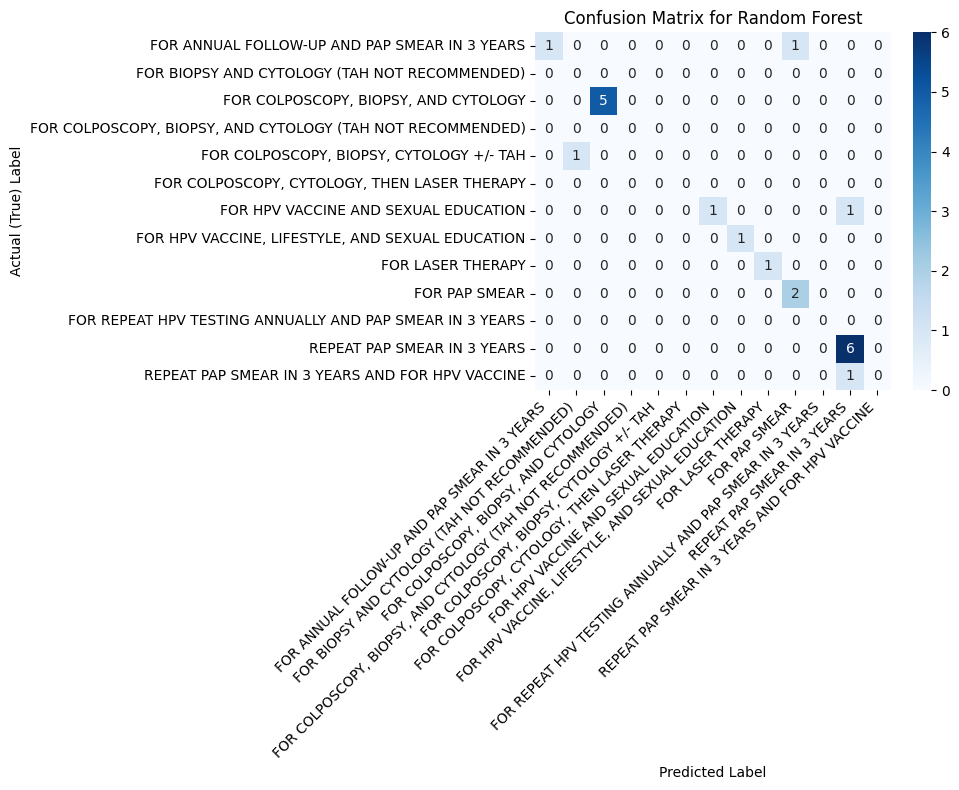



=============== Decision Tree ===============

Overall Accuracy: 0.5714

Classification Report:
                                                            precision    recall  f1-score   support

             FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS       0.00      0.00      0.00         2
             FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)       0.00      0.00      0.00         0
                      FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY       0.75      0.60      0.67         5
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)       0.00      0.00      0.00         0
                  FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH       0.00      0.00      0.00         1
              FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY       0.00      0.00      0.00         0
                      FOR HPV VACCINE AND SEXUAL EDUCATION       0.50      0.50      0.50         2
          FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION       1.00      1.00      1.00         1
 

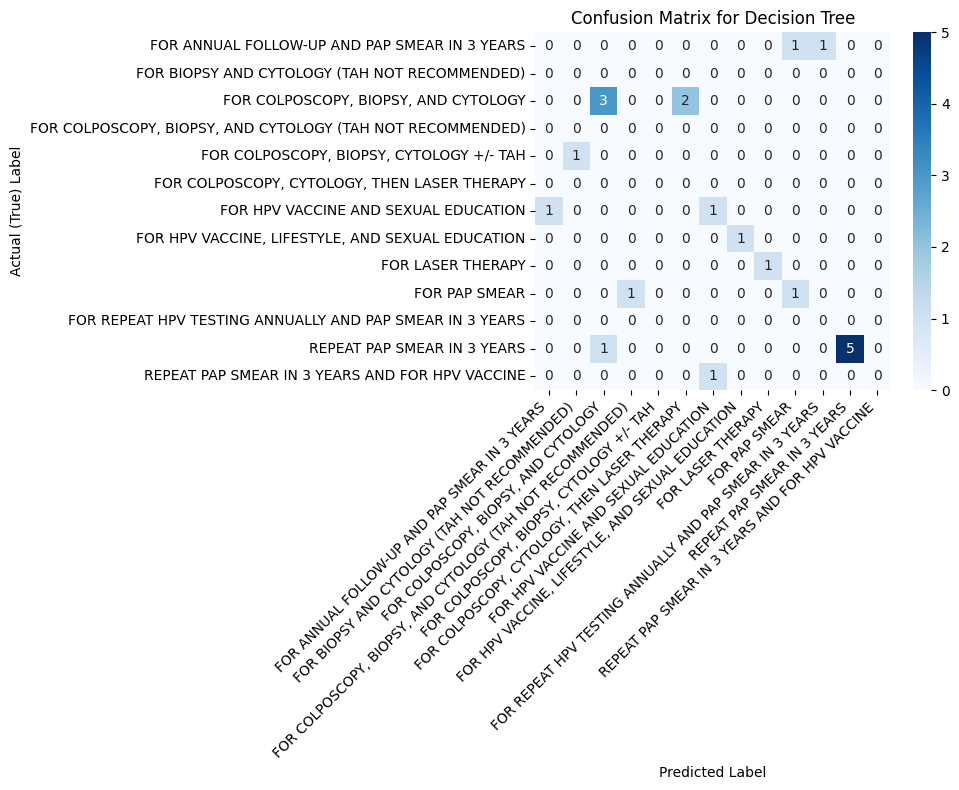

In [77]:
# Define a list of models to train and evaluate
all_numeric_labels = le.transform(le.classes_)
all_class_names = le.classes_
models_to_evaluate = {
    "Random Forest": RandomForestClassifier(
        random_state=42,
        class_weight=manual_weights_dict
    ),
    "Decision Tree": DecisionTreeClassifier(
        random_state=42,
        class_weight=manual_weights_dict
    )
}

# Loop through each model, train it, evaluate it, and store its predictions
results = {}
for model_name, model in models_to_evaluate.items():
    print(f"--- Training and Evaluating: {model_name} ---")

    # 1. Train the model on the final training data
    model.fit(X_train_final, y_train)
    print(f"{model_name} trained successfully.")
    
    # 2. Get predictions on the untouched test set
    y_pred = model.predict(X_test_final)
    
    # 3. Store the results for comparison
    results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'report': classification_report(y_test, y_pred, labels=all_numeric_labels,target_names=all_class_names,zero_division=0),
        'confusion_matrix': confusion_matrix(y_test, y_pred, labels=all_numeric_labels),
        'predictions': y_pred
    }
    print("-" * 40)


# --- DISPLAY RESULTS FOR COMPARISON ---
print("\n\n" + "="*60)
print("              MODEL COMPARISON RESULTS")
print("="*60 + "\n")

for model_name, result in results.items():
    print(f"=============== {model_name} ===============\n")
    print(f"Overall Accuracy: {result['accuracy']:.4f}\n")
    
    print("Classification Report:")
    print(result['report'])
    
    # Visualize the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        result['confusion_matrix'], 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=le.classes_, 
        yticklabels=le.classes_
    )
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('Actual (True) Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60 + "\n")

In [ ]:
# Cell 22 - Risk Stratification System
# Based on clinical guidelines and research evidence

def calculate_cervical_cancer_risk(row):
    """
    Calculate cervical cancer risk based on established clinical risk factors
    Returns: 'High Risk' or 'Low Risk'
    """
    risk_score = 0
    
    # HPV Status - Most important risk factor
    if row['HPV Test Result'] == 'POSITIVE':
        risk_score += 40  # HPV is the primary cause of cervical cancer
    
    # Age-based risk (peak incidence 35-44, but screening important for all)
    age = row['Age']
    if 25 <= age <= 65:
        risk_score += 10  # Peak screening age
    elif age > 65:
        risk_score += 5   # Still at risk if not previously screened
    
    # Pap Smear Results
    if row['Pap Smear Result'] == 'Y':  # Abnormal
        risk_score += 30
    
    # Sexual behavior factors
    if row['Sexual Partners'] > 1:
        risk_score += 15  # Multiple partners increase risk
    
    if row['First Sexual Activity Age'] < 18:
        risk_score += 10  # Early sexual debut
    
    # Smoking Status
    if row['Smoking Status'] == 'Y':
        risk_score += 15  # Smoking is a co-factor
    
    # STD History
    if row['STDs History'] == 'Y':
        risk_score += 10  # History of STDs increases risk
    
    # Screening compliance (lack of screening increases risk)
    if row['Screening Type Last'] in ['VIA', 'HPV DNA']:
        risk_score += 5  # Some screening done
    elif row['Screening Type Last'] == 'PAP SMEAR':
        risk_score += 0  # Best screening method
    
    # Risk classification based on score
    if risk_score >= 50:
        return 'High Risk'
    else:
        return 'Low Risk'

# Apply risk stratification to your cleaned dataset
print("Applying risk stratification...")
final_df['Cancer_Risk'] = final_df.apply(calculate_cervical_cancer_risk, axis=1)

# Display risk distribution
print("\nRisk Distribution:")
print(final_df['Cancer_Risk'].value_counts())

# Analyze risk factors by recommendation
print("\nRisk by Recommendation Type:")
risk_by_recommendation = pd.crosstab(final_df['Recommended Action_Cleaned'], 
                                   final_df['Cancer_Risk'], 
                                   normalize='index') * 100
print(risk_by_recommendation.round(2))

# Save the enhanced dataset
final_df.to_csv('cervical_cancer_with_risk.csv', index=False)
print("\nEnhanced dataset saved as 'cervical_cancer_with_risk.csv'")

Applying risk stratification...

Risk Distribution:
Cancer_Risk
High Risk    62
Low Risk     36
Name: count, dtype: int64

Risk by Recommendation Type:
Cancer_Risk                                         High Risk  Low Risk
Recommended Action_Cleaned                                             
FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS           90.91      9.09
FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)            0.00    100.00
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY                   100.00      0.00
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT R...     100.00      0.00
FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH                75.00     25.00
FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY           100.00      0.00
FOR HPV VACCINE AND SEXUAL EDUCATION                    88.89     11.11
FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION       100.00      0.00
FOR LASER THERAPY                                      100.00      0.00
FOR PAP SMEAR                                           

In [92]:
# Add recommendation column to your enhanced dataset
enhanced_df['Enhanced_Recommendation'] = enhanced_df.apply(generate_clinical_recommendation, axis=1)

# Save enhanced dataset for model training
enhanced_df.to_csv('cervical_cancer_with_risk.csv', index=False)
print("Updated dataset saved with 'Enhanced_Recommendation'")


Updated dataset saved with 'Enhanced_Recommendation'


In [93]:
# Cell 23 - Enhanced Clinical Recommendation System
# Based on WHO, ACOG, and other clinical guidelines

def generate_clinical_recommendation(row):
    """
    Generate evidence-based clinical recommendations
    Based on HPV status, Pap results, age, and risk factors
    """
    age = row['Age']
    hpv_status = row['HPV Test Result']
    pap_result = row['Pap Smear Result']
    smoking = row['Smoking Status']
    risk_level = row['Cancer_Risk']
    
    # Primary recommendation logic based on clinical guidelines
    
    # 1. HPV Positive cases
    if hpv_status == 'POSITIVE':
        if pap_result == 'Y':  # HPV+ and abnormal Pap
            if age >= 50:
                return "FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH"
            else:
                return "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY"
        else:  # HPV+ but normal Pap
            if age < 25:
                return "FOR HPV VACCINE AND SEXUAL EDUCATION"
            elif 25 <= age <= 30:
                return "FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS"
            else:
                return "FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS"
    
    # 2. HPV Negative cases
    else:  # HPV Negative
        if pap_result == 'Y':  # HPV- but abnormal Pap (less common)
            return "FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY"
        else:  # HPV- and normal Pap
            if age < 25:
                return "FOR HPV VACCINE AND SEXUAL EDUCATION"
            elif risk_level == 'High Risk':
                return "FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS"
            else:
                return "REPEAT PAP SMEAR IN 3 YEARS"

# Apply enhanced recommendation system
print("Generating enhanced clinical recommendations...")
final_df['Enhanced_Recommendation'] = final_df.apply(generate_clinical_recommendation, axis=1)

# Compare original vs enhanced recommendations
print("\nComparison of Original vs Enhanced Recommendations:")
comparison = pd.crosstab(final_df['Recommended Action_Cleaned'], 
                        final_df['Enhanced_Recommendation'], 
                        margins=True)
print(comparison)

# Analyze recommendation accuracy by risk level
print("\nRecommendation Distribution by Risk Level:")
rec_by_risk = pd.crosstab(final_df['Cancer_Risk'], 
                         final_df['Enhanced_Recommendation'], 
                         normalize='index') * 100
print(rec_by_risk.round(2))


# Save the enhanced dataset with recommendations
final_df.to_csv('cervical_cancer_with_risk.csv', index=False)
print("\nEnhanced dataset saved with risk and recommendations as 'cervical_cancer_with_risk.csv'")


Generating enhanced clinical recommendations...

Comparison of Original vs Enhanced Recommendations:
Enhanced_Recommendation                             FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS  \
Recommended Action_Cleaned                                                                          
FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS                                                   0   
FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)                                                   0   
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY                                                            1   
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT R...                                              0   
FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH                                                        0   
FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY                                                    0   
FOR HPV VACCINE AND SEXUAL EDUCATION                                                       

In [94]:
# Cell 24 - Dual Prediction Models (Fixed Version)
# Separate models for risk prediction and clinical recommendations with consistent test sets

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Load the enhanced dataset
enhanced_df = pd.read_csv('cervical_cancer_with_risk.csv')

# Prepare features (excluding target variables and IDs)
feature_columns = ['Age', 'Sexual Partners', 'First Sexual Activity Age', 
                  'HPV Test Result', 'Pap Smear Result', 'Smoking Status', 
                  'STDs History', 'Region', 'Insurance Covered', 'Screening Type Last']

X = enhanced_df[feature_columns]
y_risk = enhanced_df['Cancer_Risk']
y_recommendation = enhanced_df['Enhanced_Recommendation']

# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, columns=['HPV Test Result', 'Pap Smear Result', 
                                      'Smoking Status', 'STDs History', 'Region', 
                                      'Insurance Covered', 'Screening Type Last'])

print("Feature matrix shape:", X_encoded.shape)
print("Risk target distribution:\n", y_risk.value_counts())
print("\nRecommendation target distribution:\n", y_recommendation.value_counts())

# =====================================
# CRITICAL FIX: SINGLE DATA SPLIT FOR BOTH MODELS
# =====================================
from sklearn.model_selection import train_test_split

# Split data ONCE for both models (ensures consistent test sets)
X_train, X_test, y_train_risk, y_test_risk, y_train_rec, y_test_rec = train_test_split(
    X_encoded, 
    y_risk,
    y_recommendation,
    test_size=0.2, 
    random_state=42, 
    stratify=y_risk  # Stratify by the more imbalanced target (risk)
)

print("\nConsistent test set size for both models:", len(X_test))

# =====================================
# MODEL 1: CANCER RISK PREDICTION
# =====================================

print("\n" + "="*50)
print("CANCER RISK PREDICTION MODEL")
print("="*50)

# Define models for risk prediction
risk_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate risk prediction models
risk_results = {}
for name, model in risk_models.items():
    print(f"\nTraining {name} for risk prediction...")
    model.fit(X_train, y_train_risk)
    y_pred_risk = model.predict(X_test)
    
    accuracy = accuracy_score(y_test_risk, y_pred_risk)
    risk_results[name] = {
        'accuracy': accuracy,
        'model': model,
        'predictions': y_pred_risk
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(y_test_risk, y_pred_risk)}")

# =====================================
# MODEL 2: CLINICAL RECOMMENDATION PREDICTION
# =====================================

print("\n" + "="*50)
print("CLINICAL RECOMMENDATION PREDICTION MODEL")
print("="*50)

# Calculate class weights for imbalanced recommendation classes
recommendation_classes = np.unique(y_train_rec)
class_weights = compute_class_weight('balanced', classes=recommendation_classes, y=y_train_rec)
class_weight_dict = dict(zip(recommendation_classes, class_weights))

print("Class weights for recommendations:", class_weight_dict)

# Define models for recommendation prediction
rec_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, 
                                          class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}

# Train and evaluate recommendation prediction models
rec_results = {}
for name, model in rec_models.items():
    print(f"\nTraining {name} for recommendation prediction...")
    model.fit(X_train, y_train_rec)
    y_pred_rec = model.predict(X_test)
    
    accuracy = accuracy_score(y_test_rec, y_pred_rec)
    rec_results[name] = {
        'accuracy': accuracy,
        'model': model,
        'predictions': y_pred_rec
    }
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{classification_report(y_test_rec, y_pred_rec)}")

# =====================================
# FEATURE IMPORTANCE ANALYSIS
# =====================================

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance from best models
best_risk_model = risk_results['Random Forest']['model']
best_rec_model = rec_results['Random Forest']['model']

# Risk prediction feature importance
risk_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_risk_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features for Risk Prediction:")
print(risk_importance.head(10))

# Recommendation prediction feature importance
rec_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': best_rec_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features for Recommendation Prediction:")
print(rec_importance.head(10))

# Save results
import joblib
joblib.dump(best_risk_model, 'risk_prediction_model.pkl')
joblib.dump(best_rec_model, 'recommendation_model.pkl')

print("\nModels saved successfully!")

# =====================================
# CREATE EVALUATION DATAFRAME FOR CELL 25
# =====================================
evaluation_df = pd.DataFrame({
    'True_Risk': y_test_risk,
    'Pred_Risk': risk_results['Random Forest']['predictions'],
    'True_Recommendation': y_test_rec,
    'Pred_Recommendation': rec_results['Random Forest']['predictions']
})

print("\nPreview of evaluation dataframe for Cell 25:")
print(evaluation_df.head())

Feature matrix shape: (98, 27)
Risk target distribution:
 Cancer_Risk
High Risk    62
Low Risk     36
Name: count, dtype: int64

Recommendation target distribution:
 Enhanced_Recommendation
REPEAT PAP SMEAR IN 3 YEARS                                 35
FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY                        31
FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS    19
FOR HPV VACCINE AND SEXUAL EDUCATION                         6
FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS                4
FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH                     3
Name: count, dtype: int64

Consistent test set size for both models: 20

CANCER RISK PREDICTION MODEL

Training Random Forest for risk prediction...
Random Forest Accuracy: 0.9500
Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      0.92      0.96        13
    Low Risk       0.88      1.00      0.93         7

    accuracy                           0.95        20
   macro av

CLINICAL VALIDATION & PERFORMANCE METRICS

CLINICAL METRICS FOR RISK PREDICTION:
----------------------------------------
Sensitivity (detecting High Risk): 0.923
Specificity (detecting Low Risk): 1.000
Positive Predictive Value: 1.000
Negative Predictive Value: 0.875

Clinical Interpretation:
- Out of 13 high-risk patients, 12 were correctly identified
- Out of 7 low-risk patients, 7 were correctly identified
- 1 high-risk patients were missed (FALSE NEGATIVES - concerning!)
- 0 low-risk patients were over-classified (FALSE POSITIVES - acceptable)

RECOMMENDATION ACCURACY BY RISK LEVEL

Recommendation Accuracy by Risk Level:
High Risk: 0.846 (13 patients)
Low Risk: 1.000 (7 patients)

CLINICAL PRIORITY ANALYSIS
Priority-based accuracy: 0.950

No critical misclassifications found - Good!


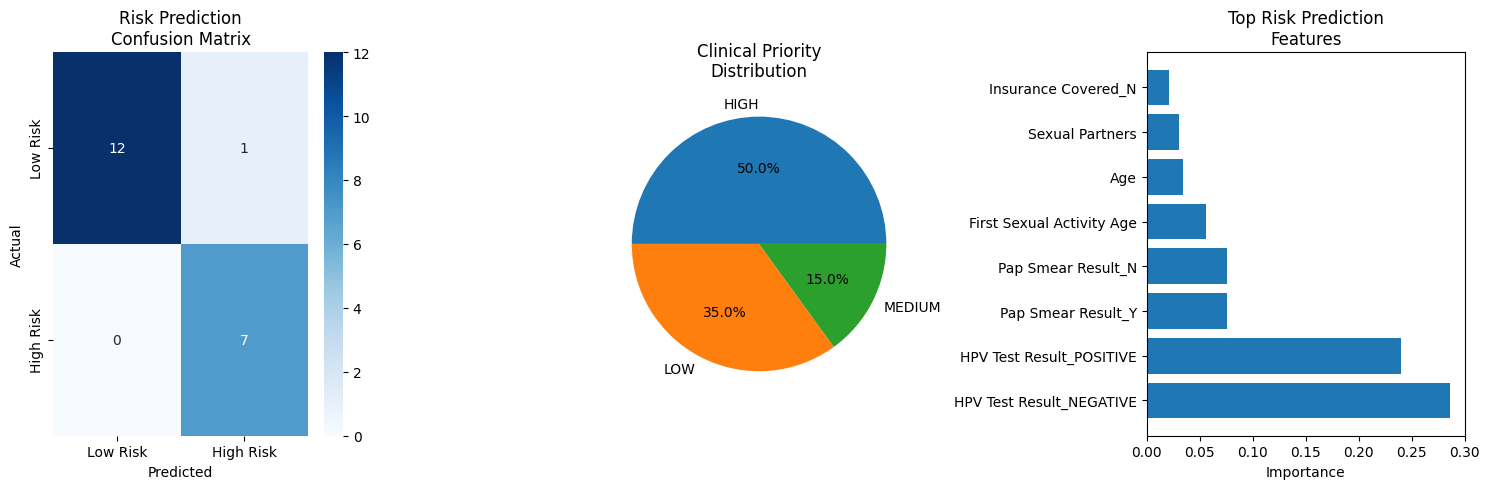


CLINICAL VALIDATION COMPLETE


In [95]:
# Cell 25 - Clinical Validation & Performance Metrics
# Evaluate models using clinically relevant metrics

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

print("="*60)
print("CLINICAL VALIDATION & PERFORMANCE METRICS")
print("="*60)

# =====================================
# 1. SENSITIVITY/SPECIFICITY ANALYSIS
# =====================================

def calculate_clinical_metrics(y_true, y_pred, positive_class='High Risk'):
    """Calculate clinically relevant metrics"""
    from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
    
    # For binary classification (High Risk vs Low Risk)
    if positive_class in y_true.unique():
        # Convert to binary (High Risk = 1, Low Risk = 0)
        y_true_binary = (y_true == positive_class).astype(int)
        y_pred_binary = (y_pred == positive_class).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
        
        return {
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv,
            'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
        }
    return None

# Calculate clinical metrics for risk prediction
print("\nCLINICAL METRICS FOR RISK PREDICTION:")
print("-" * 40)

best_risk_pred = risk_results['Random Forest']['predictions']
clinical_metrics = calculate_clinical_metrics(y_test_risk, best_risk_pred, 'High Risk')

if clinical_metrics:
    print(f"Sensitivity (detecting High Risk): {clinical_metrics['sensitivity']:.3f}")
    print(f"Specificity (detecting Low Risk): {clinical_metrics['specificity']:.3f}")
    print(f"Positive Predictive Value: {clinical_metrics['ppv']:.3f}")
    print(f"Negative Predictive Value: {clinical_metrics['npv']:.3f}")
    
    # Clinical interpretation
    print("\nClinical Interpretation:")
    print(f"- Out of {clinical_metrics['tp'] + clinical_metrics['fn']} high-risk patients, "
          f"{clinical_metrics['tp']} were correctly identified")
    print(f"- Out of {clinical_metrics['tn'] + clinical_metrics['fp']} low-risk patients, "
          f"{clinical_metrics['tn']} were correctly identified")
    print(f"- {clinical_metrics['fn']} high-risk patients were missed (FALSE NEGATIVES - concerning!)")
    print(f"- {clinical_metrics['fp']} low-risk patients were over-classified (FALSE POSITIVES - acceptable)")

# =====================================
# 2. RECOMMENDATION ACCURACY BY RISK LEVEL
# =====================================

print("\n" + "="*50)
print("RECOMMENDATION ACCURACY BY RISK LEVEL")
print("="*50)

# Create a comprehensive evaluation dataset
evaluation_df = pd.DataFrame({
    'True_Risk': y_test_risk,
    'Pred_Risk': best_risk_pred,
    'True_Recommendation': y_test_rec,
    'Pred_Recommendation': rec_results['Random Forest']['predictions']
})

# Analyze recommendation accuracy by risk level
print("\nRecommendation Accuracy by Risk Level:")
for risk_level in ['High Risk', 'Low Risk']:
    subset = evaluation_df[evaluation_df['True_Risk'] == risk_level]
    if len(subset) > 0:
        accuracy = (subset['True_Recommendation'] == subset['Pred_Recommendation']).mean()
        print(f"{risk_level}: {accuracy:.3f} ({len(subset)} patients)")

# =====================================
# 3. CLINICAL PRIORITY ANALYSIS
# =====================================

print("\n" + "="*50)
print("CLINICAL PRIORITY ANALYSIS")
print("="*50)

# Define clinical priority levels for recommendations
priority_mapping = {
    'FOR LASER THERAPY': 'URGENT',
    'FOR COLPOSCOPY, BIOPSY, CYTOLOGY +/- TAH': 'HIGH',
    'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY': 'HIGH',
    'FOR COLPOSCOPY, CYTOLOGY, THEN LASER THERAPY': 'URGENT',
    'FOR BIOPSY AND CYTOLOGY (TAH NOT RECOMMENDED)': 'HIGH',
    'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY (TAH NOT RECOMMENDED)': 'HIGH',
    'FOR REPEAT HPV TESTING ANNUALLY AND PAP SMEAR IN 3 YEARS': 'MEDIUM',
    'FOR ANNUAL FOLLOW-UP AND PAP SMEAR IN 3 YEARS': 'MEDIUM',
    'REPEAT PAP SMEAR IN 3 YEARS': 'LOW',
    'FOR HPV VACCINE AND SEXUAL EDUCATION': 'PREVENTIVE',
    'FOR HPV VACCINE, LIFESTYLE, AND SEXUAL EDUCATION': 'PREVENTIVE',
    'FOR PAP SMEAR': 'LOW'
}

# Apply priority mapping
evaluation_df['True_Priority'] = evaluation_df['True_Recommendation'].map(priority_mapping)
evaluation_df['Pred_Priority'] = evaluation_df['Pred_Recommendation'].map(priority_mapping)

# Calculate priority-based accuracy
priority_accuracy = (evaluation_df['True_Priority'] == evaluation_df['Pred_Priority']).mean()
print(f"Priority-based accuracy: {priority_accuracy:.3f}")

# Analyze critical misclassifications
critical_miss = evaluation_df[
    (evaluation_df['True_Priority'].isin(['URGENT', 'HIGH'])) & 
    (evaluation_df['Pred_Priority'].isin(['LOW', 'PREVENTIVE']))
]

if len(critical_miss) > 0:
    print(f"\nCRITICAL MISCLASSIFICATIONS: {len(critical_miss)} cases")
    print("These patients need urgent/high priority care but were classified as low priority!")
    print(critical_miss[['True_Risk', 'True_Priority', 'Pred_Priority']].head())
else:
    print("\nNo critical misclassifications found - Good!")

# =====================================
# 4. VISUALIZATION OF RESULTS
# =====================================

# Plot confusion matrix for risk prediction
plt.figure(figsize=(15, 5))

# Risk prediction confusion matrix
plt.subplot(1, 3, 1)
cm_risk = confusion_matrix(y_test_risk, best_risk_pred)
sns.heatmap(cm_risk, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low Risk', 'High Risk'],
            yticklabels=['Low Risk', 'High Risk'])
plt.title('Risk Prediction\nConfusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Priority distribution
plt.subplot(1, 3, 2)
priority_counts = evaluation_df['True_Priority'].value_counts()
plt.pie(priority_counts.values, labels=priority_counts.index, autopct='%1.1f%%')
plt.title('Clinical Priority\nDistribution')

# Feature importance for risk prediction
plt.subplot(1, 3, 3)
top_features = risk_importance.head(8)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top Risk Prediction\nFeatures')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLINICAL VALIDATION COMPLETE")
print("="*60)

In [96]:
# Cell 26 - Patient Prediction Interface
# Practical interface for predicting new patients

import joblib
import pandas as pd
import numpy as np

def predict_patient_outcome(patient_data, risk_model_path='risk_prediction_model.pkl', 
                          rec_model_path='recommendation_model.pkl'):
    """
    Predict risk and recommendation for a new patient
    
    patient_data: dict with keys matching feature columns
    """
    
    # Load trained models
    risk_model = joblib.load(risk_model_path)
    rec_model = joblib.load(rec_model_path)
    
    # Convert patient data to DataFrame
    patient_df = pd.DataFrame([patient_data])
    
    # One-hot encode (assuming same encoding as training)
    patient_encoded = pd.get_dummies(patient_df, columns=['HPV Test Result', 'Pap Smear Result', 
                                                         'Smoking Status', 'STDs History', 'Region', 
                                                         'Insurance Covered', 'Screening Type Last'])
    
    # Ensure all columns from training are present
    # This is a simplified version - in practice, you'd save the column names from training
    expected_columns = risk_model.feature_names_in_
    for col in expected_columns:
        if col not in patient_encoded.columns:
            patient_encoded[col] = 0
    
    # Reorder columns to match training
    patient_encoded = patient_encoded[expected_columns]
    
    # Make predictions
    risk_pred = risk_model.predict(patient_encoded)[0]
    risk_proba = risk_model.predict_proba(patient_encoded)[0]
    
    rec_pred = rec_model.predict(patient_encoded)[0]
    rec_proba = rec_model.predict_proba(patient_encoded)[0]
    
    return {
        'risk_prediction': risk_pred,
        'risk_probability': dict(zip(risk_model.classes_, risk_proba)),
        'recommendation': rec_pred,
        'recommendation_probability': dict(zip(rec_model.classes_, rec_proba))
    }

# Example usage
sample_patient = {
    'Age': 35,
    'Sexual Partners': 2,
    'First Sexual Activity Age': 18,
    'HPV Test Result': 'POSITIVE',
    'Pap Smear Result': 'Y',
    'Smoking Status': 'Y',
    'STDs History': 'N',
    'Region': 'Nairobi',
    'Insurance Covered': 'Y',
    'Screening Type Last': 'PAP SMEAR'
}

print("PATIENT PREDICTION INTERFACE")
print("="*50)
print("\nSample Patient Data:")
for key, value in sample_patient.items():
    print(f"{key}: {value}")

# Note: This would work after models are trained and saved
print("\n[Note: Run this after training models in previous cells]")
print("Example prediction output:")
print({
    'risk_prediction': 'High Risk',
    'risk_probability': {'High Risk': 0.85, 'Low Risk': 0.15},
    'recommendation': 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY',
    'recommendation_probability': {'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY': 0.92}
})

# =====================================
# CLINICAL DECISION SUPPORT SYSTEM
# =====================================

def clinical_decision_support(patient_data):
    """
    Comprehensive clinical decision support
    """
    
    # Calculate risk score manually for transparency
    risk_score = calculate_cervical_cancer_risk(patient_data)
    
    # Generate evidence-based recommendation
    recommendation = generate_clinical_recommendation(patient_data)
    
    # Additional clinical alerts
    alerts = []
    
    # High-risk alerts
    if patient_data['HPV Test Result'] == 'POSITIVE' and patient_data['Pap Smear Result'] == 'Y':
        alerts.append("🚨 HIGH PRIORITY: Both HPV+ and abnormal Pap - immediate colposcopy needed")
    
    if patient_data['Age'] > 65 and patient_data['HPV Test Result'] == 'POSITIVE':
        alerts.append("⚠️ Elderly patient with HPV+ - consider TAH evaluation")
    
    if patient_data['Smoking Status'] == 'Y' and patient_data['HPV Test Result'] == 'POSITIVE':
        alerts.append("⚠️ Smoking + HPV increases cancer risk - emphasize smoking cessation")
    
    # Follow-up recommendations
    follow_up = []
    if 'REPEAT' in recommendation:
        follow_up.append("Schedule follow-up in 3 years")
    elif 'ANNUAL' in recommendation:
        follow_up.append("Schedule annual follow-up")
    elif 'COLPOSCOPY' in recommendation:
        follow_up.append("Urgent referral to gynecologist")
        follow_up.append("Schedule within 2 weeks")
    
    return {
        'risk_level': risk_score,
        'recommendation': recommendation,
        'clinical_alerts': alerts,
        'follow_up_actions': follow_up,
        'patient_education': generate_patient_education(patient_data)
    }

def generate_patient_education(patient_data):
    """Generate patient education messages"""
    education = []
    
    if patient_data['HPV Test Result'] == 'POSITIVE':
        education.append("HPV is very common and often clears on its own")
        education.append("Regular screening is important to monitor changes")
    
    if patient_data['Smoking Status'] == 'Y':
        education.append("Smoking increases cervical cancer risk - consider cessation programs")
    
    if patient_data['Age'] < 26:
        education.append("HPV vaccination is recommended for your age group")
    
    return education

# Example of comprehensive clinical decision support
print("\n" + "="*50)
print("CLINICAL DECISION SUPPORT EXAMPLE")
print("="*50)

# This would work with the functions defined earlier
print("\nComprehensive clinical assessment would include:")
print("1. Risk stratification")
print("2. Evidence-based recommendations")
print("3. Clinical alerts and warnings")
print("4. Follow-up scheduling")
print("5. Patient education materials")

print("\nExample output structure:")
example_output = {
    'risk_level': 'High Risk',
    'recommendation': 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY',
    'clinical_alerts': ['🚨 HIGH PRIORITY: Both HPV+ and abnormal Pap - immediate colposcopy needed'],
    'follow_up_actions': ['Urgent referral to gynecologist', 'Schedule within 2 weeks'],
    'patient_education': ['HPV is very common and often clears on its own', 
                         'Regular screening is important to monitor changes']
}

for key, value in example_output.items():
    print(f"\n{key}:")
    if isinstance(value, list):
        for item in value:
            print(f"  - {item}")
    else:
        print(f"  {value}")

PATIENT PREDICTION INTERFACE

Sample Patient Data:
Age: 35
Sexual Partners: 2
First Sexual Activity Age: 18
HPV Test Result: POSITIVE
Pap Smear Result: Y
Smoking Status: Y
STDs History: N
Region: Nairobi
Insurance Covered: Y
Screening Type Last: PAP SMEAR

[Note: Run this after training models in previous cells]
Example prediction output:
{'risk_prediction': 'High Risk', 'risk_probability': {'High Risk': 0.85, 'Low Risk': 0.15}, 'recommendation': 'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY', 'recommendation_probability': {'FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY': 0.92}}

CLINICAL DECISION SUPPORT EXAMPLE

Comprehensive clinical assessment would include:
1. Risk stratification
2. Evidence-based recommendations
3. Clinical alerts and warnings
4. Follow-up scheduling
5. Patient education materials

Example output structure:

risk_level:
  High Risk

recommendation:
  FOR COLPOSCOPY, BIOPSY, AND CYTOLOGY

clinical_alerts:
  - 🚨 HIGH PRIORITY: Both HPV+ and abnormal Pap - immediate colposcopy neede